In [1]:
##################################################################################################################
### Imports                                                                                                    ###
##################################################################################################################

# Plots
# -----
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib import rcParams

# Math and Physics
# ----------------
from math import tau
from math import inf
import numpy as np
import numpy.random as npr
import scipy.constants as const
from scipy.integrate import dblquad
from scipy.integrate import simps
from scipy.optimize import minimize
from scipy.special import factorial

# Data Reading
# ------------
import pandas as pd
import os

# Timing
# ------
import time as tm

In [2]:
##################################################################################################################
### Global Constants                                                                                           ###
##################################################################################################################

# General
# -------
alpha          = const.physical_constants[r"fine-structure constant"][0]
Me_keV         = const.physical_constants[r"electron mass energy equivalent in MeV"][0] * const.mega / const.kilo
Mp_g           = const.physical_constants[r"proton mass"][0] * const.kilo
kB_keV_K       = const.physical_constants[r"Boltzmann constant in eV/K"][0] / const.kilo
NA             = const.physical_constants[r"Avogadro constant"][0]
hbar_keVs      = const.physical_constants[r"Planck constant in eV s"][0] / (tau * const.kilo)
c_cm_s         = const.physical_constants[r"speed of light in vacuum"][0] / const.centi
au_cm          = const.au / const.centi
day_s_d        = const.day
year_s_y       = const.year
Rsol_cm        = 6.957 * 1e10 # Source: https://www.wolframalpha.com/input/?i=solar%20radius%20in%20cm
XenonMass_AMU  = 131.293      # Source: https://www.wolframalpha.com/input/?i=xenon+mass+in+amu
XenonAtomsInMg = NA * const.mega / XenonMass_AMU

# Likelihood
# ----------
magicalLikelihoodNumber = 2.71

In [3]:
################################################################################################################
### Global Functions                                                                                         ###
################################################################################################################

# Mathematics
# -----------
def F(w, y):
    '''
    The double integral F(w, y), as defined in http://dx.doi.org/10.1088/1475-7516/2013/12/008.
    
    Input:
    ------
    * w - omega / T (refer the reference above).
          An array, where each cell relates to a specific radius in the Sun.
    * y - kappa_s / (2 m_e T)^(1/2) (refer the reference above).
          An array, where each cell relates to a specific radius in the Sun.
    
    Output:
    -------
    An array which contains the result.
    '''
    result = []
    for i in range(w.size):
        result.append(dblquad(lambda t, x, y: x * np.exp(-x**2) * t**3 / (t**2 + y**2)**2,
                              0,
                              np.inf,
                              lambda x: np.sqrt(x**2 + w[i]) - x,
                              lambda x: np.sqrt(x**2 + w[i]) + x,
                              (y[i],))[0])
    return np.array(result)

# Auxiliary
# ---------
def GetFactorial(array):
    result = int(np.rint(array))
    for i in range(result.size):
        result[i] = factorial

def GetBetaSquared(m_keV, omega_keV):
    return 1 - (m_keV / omega_keV)**2

def GetBetaSquaredArray(m_keV, omega_keV):
    betaSquared                  = GetBetaSquared(m_keV, omega_keV)
    betaSquared[betaSquared < 0] = 0
    return betaSquared

def GetBetaCubedArray(m_keV, omega_keV):
    return GetBetaSquaredArray(m_keV, omega_keV)**(3 / 2)

def GetBetaToTheFourthArray(m_keV, omega_keV):
    return GetBetaSquaredArray(m_keV, omega_keV)**2

def BaseTenExponentiation(scalePower):
    '''
    Input parameters:
    -----------------
    * scalePower - A string, describing a power of the number 10.
    
    Output:
    -------
    The numerical value 10^scalePower.
    '''
    return np.float_power(10, int(scalePower))

def CouplingPowerAndMassToLaTeX(couplingPower, m_keV, coefficient = 1):
    '''
    Input parameters:
    -----------------
    * couplingPower - A string, where the coupling gee equals to the numerical value 10^couplingPower.
    * m_keV         - The mass of the particle.
    
    Output:
    -------
    A LaTeX string which states in a bold text that gee=10^couplingPower and specifies the mass, all enclosed by
    parentheses.
    '''
    if(coefficient == 1):
        coefficient = r""
    else:
        coefficient = str(coefficient) + r"\cdot"
    return r"$\displaystyle{\boldsymbol{\left(g_{S}=" + coefficient + r"10^{" + couplingPower + r"}\,,\ m=" \
                                                              + str(m_keV) + r"\textrm{ \textbf{keV}}\right)}}$"

def InitializeOmega(S):
    if(S == 1):
        numberOfOmegaGridPoints = S1numberOfOmegaGridPoints
        linear                  = S1Linear
        if(linear):
            minOmega_keV = S1minOmegaLin_keV
            maxOmega_keV = S1maxOmegaLin_keV
        else:
            minOmega_keV = S1minOmegaLog_keV
            maxOmega_keV = S1maxOmegaLog_keV
    elif(S == 2):
        numberOfOmegaGridPoints = S2numberOfOmegaGridPoints
        linear                  = S2Linear
        if(linear):
            minOmega_keV = S2minOmegaLin_keV
            maxOmega_keV = S2maxOmegaLin_keV
        else:
            minOmega_keV = S2minOmegaLog_keV
            maxOmega_keV = S2maxOmegaLog_keV
    else:
        PrintUnknownS(S, r"InitializeOmega")
        return
    
    dOmega_keV = np.zeros(numberOfOmegaGridPoints)
    if(linear):
        omega_keV = np.linspace(minOmega_keV, maxOmega_keV, numberOfOmegaGridPoints)
        dOmega_keV.fill((maxOmega_keV - minOmega_keV) / (numberOfOmegaGridPoints - 1))
    else:
        omega_keV = np.logspace(minOmega_keV, maxOmega_keV, numberOfOmegaGridPoints)
        for i in range(numberOfOmegaGridPoints):
            if(i != 0 and i != numberOfOmegaGridPoints - 1):
                dOmega_keV[i] = 10**(np.mean(np.log(omega_keV[i:i + 1]) / np.log(10))) \
                                                        - 10**(np.mean(np.log(omega_keV[i - 1:i]) / np.log(10)))
            elif(i == 0):
                dOmega_keV[i] = 10**(np.mean(np.log(omega_keV[i:i + 1]) / np.log(10))) \
                                                                       - 10**(np.log(omega_keV[i]) / np.log(10))
            else:
                dOmega_keV[i] = 10**(np.log(omega_keV[i]) / np.log(10)) \
                                                        - 10**(np.mean(np.log(omega_keV[i - 1:i]) / np.log(10)))
    
    return (omega_keV, dOmega_keV)


def Gaussian(x, mu, sigma):
    return np.exp(- np.power((x - mu) / sigma, 2) / 2) / (np.sqrt(tau) * sigma)

def Poisson(k, mu):
    if(mu == 0):
        result = np.zeros(k.size)
        result[0] = 1
        return result
    
    kCopy = k.copy()
    kCopy[0] = 1
    logarithms = np.log(kCopy)
    return np.exp(- mu + k * np.log(mu) - np.cumsum(logarithms))

#def Poisson(k, mu):
#    if(mu == 0):
#        result = np.zeros(k.size)
#        result[0] = 1
#        return result
#    
#    logarithms = np.zeros(k.size)
#    for i in range(k.size):
#        logarithms[i] = np.log(factorial(k[i]))
#    return np.exp(- mu + k * np.log(mu) - logarithms)

def ElementwisePoisson(k, mu):
    result = np.zeros(k.size)
    for i in range(k.size):
        if(mu[i] == 0):
            if(int(np.rint(k[i])) == 0):
                result[i] = 1
            else:
                result[i] = 0
        else:
            result[i] = np.exp(- mu[i] + k[i] * np.log(mu[i]) - np.log(factorial(k[i])))
    return result

def GetSString(S):
    '''
    Input parameters:
    -----------------
    * S - Numerical value which discribes the detection channel. "1" for S1, and "2" for S2.
    '''
    if(S == 1 or S == 2):
        return r" (S = " + str(S) + r" )"
    return r""

def PrintErrorMessage(func, message, element, S = 0):
    '''
    Input parameters:
    -----------------
    * func    - The name of the calling function.
    * message - The error message.
    * element - The problematic element.
    * S       - Numerical value which discribes the detection channel. "1" for S1, and "2" for S2.
    '''
    print(func + r": " + message + r" - " + element + GetSString(S))

def PrintUnknownBosonType(bosonType, func, S = 0):
    '''
    Input parameters:
    -----------------
    * bosonType - A string, describing the nature of the boson.
    * func      - The name of the calling function.
    * S         - Numerical value which discribes the detection channel. "1" for S1, and "2" for S2.
    '''
    PrintErrorMessage(func, r"Unknown boson type", bosonType, S)

def PrintUnknownProcess(process, func, S = 0):
    '''
    Input parameters:
    -----------------
    * process - A string, describing the process.
    * func       - The name of the calling function.
    * S          - Numerical value which discribes the detection channel. "1" for S1, and "2" for S2.
    '''
    PrintErrorMessage(func, r"Unknown process", process, S)

def PrintUnknownExperiment(experiment, func, S = 0):
    '''
    Input parameters:
    -----------------
    * experiment - A string, describing the experiment.
    * func       - The name of the calling function.
    * S          - Numerical value which discribes the detection channel. "1" for S1, and "2" for S2.
    '''
    PrintErrorMessage(func, r"Unknown experiment", experiment, S)

def PrintUnknownDistribution(distribution, func, S = 0):
    '''
    Input parameters:
    -----------------
    * distribution - A string, describing the distribution.
    * func         - The name of the calling function.
    * S            - Numerical value which discribes the detection channel. "1" for S1, and "2" for S2.
    '''
    PrintErrorMessage(func, r"Unknown distribution", distribution, S)

def PrintUnknownS(S, func):
    '''
    Input parameters:
    -----------------
    * S    - Numerical value which discribes the detection channel. "1" for S1, and "2" for S2.
    * func - The name of the calling function.
    '''
    PrintErrorMessage(func, r"Unknown S parameter", S)

def PrintUnsupportedDetectionChannel(experiment, S, func):
    '''
    Input parameters:
    -----------------
    * experiment - A string, describing the experiment.
    * S          - Numerical value which discribes the detection channel. "1" for S1, and "2" for S2.
    * func       - The name of the calling function.
    '''
    PrintErrorMessage(func, r"Unsupported detection channel for the " + experiment + r" experiment", S)

def PrintEventDensityNotSupported(experiment, S, func):
    '''
    Input parameters:
    -----------------
    * experiment - A string, describing the experiment.
    * S          - Numerical value which discribes the detection channel. "1" for S1, and "2" for S2.
    * func       - The name of the calling function.
    '''
    PrintErrorMessage(func, r"Extraction of event density is not supported for the " + experiment \
                                                                                            + r" experiment", S)

# Repeated Operations
# -------------------
def GetSomega(S):
    '''
    Input parameters:
    -----------------
    * S - Numerical value which discribes the detection channel. "1" for S1, and "2" for S2.
    
    Output:
    -------
    The relevant S#omega_keV array.
    '''
    if(S == 1):
        return S1omega_keV
    elif(S == 2):
        return S2omega_keV
    else:
        PrintUnknownS(S, r"GetSomega")
        return

def GetdOmega(boundaries_keV):
    '''
    Input parameters:
    -----------------
    * boundaries_keV - The boundaries of the bins.
    
    Output:
    -------
    dOmega between the bins.
    '''
    dOmega_keV = np.zeros(boundaries_keV.size - 1)
    for i in range(boundaries_keV.size - 1):
        if(i != 0 and i != boundaries_keV.size - 2):
            dOmega_keV[i] = 10**(np.mean(np.log(boundaries_keV[i:i + 1]) / np.log(10))) \
                                                   - 10**(np.mean(np.log(boundaries_keV[i - 1:i]) / np.log(10)))
        elif(i == 0):
            dOmega_keV[i] = 10**(np.mean(np.log(boundaries_keV[i:i + 1]) / np.log(10))) \
                                                                  - 10**(np.log(boundaries_keV[i]) / np.log(10))
        else:
            dOmega_keV[i] = 10**(np.log(boundaries_keV[i]) / np.log(10)) \
                                                   - 10**(np.mean(np.log(boundaries_keV[i - 1:i]) / np.log(10)))
    return dOmega_keV

def differentialRateToDifferentialFlux(Gamma_1_cm3keV3s, omega_keV, omegaIndex, beta):
    '''
    Takes a process differential rate density, in units of (1 / cm^3 keV^3 s), and computes the differential
    flux in a distance of one astronomical unit, in units of (1 / cm^2 s keV).
    
    Input:
    ------
    * Gamma_1_cm3keV3s - The differential rate density, in units of (1 / cm^3 keV^3 s).
    * omega_keV        - Energy of incoming boson.
    * omegaIndex       - An identifier which identifies the light boson's energy inside omega_keV.
    * beta             - The velocity of the light particle.
    
    Output:
    -------
    A differential flux in a distance of 1AU, in units of (1 / cm^2 s keV).
    '''
    return 2 * omega_keV[omegaIndex]**2 * beta * Rsol_cm**3 * simps(r**2 * Gamma_1_cm3keV3s, r) \
                                                                                              / (tau * au_cm)**2

def MakeTitle(physicalObject, bosonType, couplingPower, m_keV, coefficient = 1):
    '''
    Input parameters:
    -----------------
    * physicalObject - A string that discribes the physical quantity which should be described by the title.
    * experiment     - A string, describing the boson type.
    * couplingPower  - A string, where the coupling gee equals to the numerical value 10^couplingPower.
    * m_keV          - The mass of the particle.
    
    Output:
    -------
    A title for a plot.
    '''
    return physicalObject + r" for a " + bosonType + r" Field " + CouplingPowerAndMassToLaTeX(couplingPower,
                                                                                              m_keV,
                                                                                              coefficient)

def MakePlot(x, y, title, xlabel, ylabel, loglog = False):
    '''
    Input parameters:
    -----------------
    * x      - x axis.
    * y      - y axis.
    * title  - The title of the plot.
    * xlabel - The x axis label.
    * ylabel - The y axis label.
    * loglog - Should the two axes be in log scale.
    '''
    _,ax = plt.subplots(figsize = [20, 12])
    if(loglog):
        ax.loglog(x, y)
    else:
        ax.plot(x, y)
    plt.setp(ax.get_xticklabels(), fontsize = 20)
    plt.setp(ax.get_yticklabels(), fontsize = 20)
    ax.set_title(title, fontweight = r"bold", size = 30)
    ax.set_xlabel(xlabel, fontsize = 30)
    ax.set_ylabel(ylabel, fontsize = 30)
    plt.show()

def PlotDifferentialFlux(omega_keV,
                         differentialFlux_1_cm2keVs,
                         process,
                         bosonType,
                         couplingPower,
                         m_keV,
                         redondoUnits = False,
                         loglog = False):
    '''
    Plots the differential flux against energy of the incoming boson.
    
    Input parameters:
    -----------------
    * omega_keV                  - Energy of incoming boson.
    * differentialFlux_1_cm2keVs - Differential flux.
    * process                    - A string, describing the process.
                                   Supported values are: {Photo-Production, Bremsstrahlung, Atomic Transitions}.
    * bosonType                  - A string, describing the nature of the boson.
    * couplingPower              - A string, where the coupling gee equals to the numerical value
                                   10^couplingPower.
    * m_keV                      - The mass of the particle.
    * redondoUnits               - Use the units used in Redondo's paper.
    * loglog                     - Should the two axes be in log scale.
    '''
    title = MakeTitle(process + r" Differential Flux", bosonType, couplingPower, m_keV)
    xlabel = r"$\displaystyle{\omega\,\left[\text{keV}\right]}$"
    if(process == r"Photo-Production"):
        superscript = r"pp"
    elif(process == r"Bremsstrahlung"):
        superscript = r"ff"
    elif(process == r"Atomic Transtisions"):
        superscript = r"bb+bf"
    else:
        PrintUnknownProcess(process, r"PlotDifferentialFlux")
        return
    
    if(redondoUnits):
        ylabel = r"$\displaystyle{\frac{d\Phi_{\phi}^{\text{" + superscript \
                          + r"}}}{d\omega}\,\left[10^{20}\text{m}^{-2}\,\text{y}^{-1}\,\text{keV}^{-1}\right]}$"
        differentialFlux_10p20_m2keVy = (differentialFlux_1_cm2keVs * year_s_y) / (10**20 * const.centi**2)
        MakePlot(omega_keV, differentialFlux_10p20_m2keVy, title, xlabel, ylabel, loglog)
    else:
        ylabel = r"$\displaystyle{\frac{d\Phi_{\phi}^{\text{" + superscript \
                                + r"}}}{d\omega}\,\left[\text{cm}^{-2}\,\text{s}^{-1}\,\text{keV}^{-1}\right]}$"
        MakePlot(omega_keV, differentialFlux_1_cm2keVs, title, xlabel, ylabel, loglog)

def GetSignalInS1Bins(eventDensity_1_keV, experiment):
    '''
    Input parameters:
    -----------------
    * eventDensity_1_keV - Differential number of events, as function of the incoming boson energy.
    * experiment         - A string, identifying the experiment. Supported values are: {LUX, XENON1T, XENONnT}.
    
    Output:
    -------
    Differential number of events, as function of S1.
    '''
    if(experiment == r"LUX"):
        binSize_pe = LUXBinSize_pe
        binNum     = LUXBinNum
        S1_pe      = LUXS1_pe
        if(smearingDistributionString == r"Gauss"):
            S1Sigma_pe = LUXS1Sigma_pe
    elif(experiment == r"XENON1T"):
        binSize_pe = XENON1TBinSize_pe
        binNum     = XENON1TBinNum
        S1_pe      = XENON1TS1_pe
        if(smearingDistributionString == r"Gauss"):
            S1Sigma_pe = XENON1TS1Sigma_pe
    elif(experiment == r"XENONnT"):
        binSize_pe = XENONnTBinSize_pe
        binNum     = XENONnTBinNum
        S1_pe      = XENON1TS1_pe
        if(smearingDistributionString == r"Gauss"):
            S1Sigma_pe = XENON1TS1Sigma_pe
    else:
        PrintUnknownExperiment(experiment, r"GetSignalInS1Bins")
        return
    
    signalEvents = np.zeros(SBins_pe.size)
    if(smearingDistributionString == r"Gauss"):
        for eD_1_keV, s1_pe, sig_pe in zip(eventDensity_1_keV, S1_pe, S1Sigma_pe):
            signalEvents = signalEvents + S1dOmega_keV * eD_1_keV * Gaussian(S1Bins_pe, s1_pe, sig_pe)
    elif(smearingDistributionString == r"Poisson"):
        for eD_1_keV, s1_pe in zip(eventDensity_1_keV, S1_pe):
            signalEvents = signalEvents + S1dOmega_keV * eD_1_keV * Poisson(S1Bins_pe, s1_pe)
    else:
        PrintUnknownDistribution(smearingDistributionString, r"GetSignalInS1Bins")
        return

    summedSignal = [sum(signalEvents[(SBins_pe >= max(binSize_pe * i, minimalS1Bin_pe)) \
                                                   * (SBins_pe < binSize_pe * (i + 1))]) for i in range(binNum)]
    return np.array(summedSignal)

def GetSignalInSBins(eventDensity_1_keV, experiment, S, getEventDensity = False):
    '''
    Input parameters:
    -----------------
    * eventDensity_1_keV - Differential number of events, as function of the incoming boson energy.
    * experiment         - A string, identifying the experiment. Supported values are: {LUX, XENON1T, XENONnT}.
    
    Output:
    -------
    Differential number of events, as function of S1.
    '''
    if(S == 1):
        if(getEventDensity):
            PrintEventDensityNotSupported(experiment, S, r"GetSignalInSBins")
            return
        
        if(experiment == r"LUX"):
            binNum               = LUXBinNum
            smearingDistribution = LUXS1SmearingDistribution
            binsBoundaries_pe    = LUXBinsBoundaries_pe
        elif(experiment == r"XENON1T"):
            binNum               = XENON1TBinNum
            smearingDistribution = XENON1TS1SmearingDistribution
            binsBoundaries_pe    = XENON1TBinsBoundaries_pe
        elif(experiment == r"XENONnT"):
            binNum               = XENONnTBinNum
            smearingDistribution = XENON1TS1SmearingDistribution
            binsBoundaries_pe    = XENONnTBinsBoundaries_pe
        else:
            PrintUnknownExperiment(experiment, r"GetSignalInSBins", S)
            return
        bins_pe                 = S1Bins_pe
        numberOfOmegaGridPoints = S1numberOfOmegaGridPoints
        dOmega_keV              = S1dOmega_keV
        minimalBin_pe           = minimalS1Bin_pe
    elif(S == 2):
        if(experiment == r"XENON1T"):
            binNum               = XENON1TS2BinNum
            smearingDistribution = XENON1TS2SmearingDistribution
            binsBoundaries_pe    = XENON1TS2BinsBoundaries_pe
            minimalBin_pe        = XENON1TS2BinsBoundaries_pe[0]
            experimentdOmega_keV = XENON1TS2dOmega_keV
            exposure_Mgd         = XENON1TS2Exposure_Mgd
        elif(experiment == r"LUX" or experiment == r"XENONnT"):
            PrintUnsupportedDetectionChannel(experiment, S, r"GetSignalInSBins")
            return
        else:
            PrintUnknownExperiment(experiment, r"GetSignalInSBins", S)
            return
        bins_pe                 = S2Bins_pe
        numberOfOmegaGridPoints = S2numberOfOmegaGridPoints
        dOmega_keV              = S2dOmega_keV
    else:
        PrintUnknownS(S, r"GetSignalInSBins")
    
    signalEvents = np.zeros(bins_pe.size)
    for i in range(numberOfOmegaGridPoints - 1):
        signalEvents = signalEvents + dOmega_keV[i] * eventDensity_1_keV[i] * smearingDistribution[i]
    
    summedSignal =  [sum(signalEvents[(bins_pe >= max(binsBoundaries_pe[i], minimalBin_pe)) \
                                                * (bins_pe < binsBoundaries_pe[i + 1])]) for i in range(binNum)]
    
    if(getEventDensity):
        summedSignalDensity_1_keV = [sum(signalEvents[(bins_pe >= max(binsBoundaries_pe[i], minimalBin_pe)) \
                                            * (bins_pe < binsBoundaries_pe[i + 1])]) / experimentdOmega_keV[i] \
                                                                                         for i in range(binNum)]
        return (np.array(summedSignal), np.array(summedSignalDensity_1_keV) / exposure_Mgd)
    
    return np.array(summedSignal)

def GetValidr(rAveraged, deltar):
    r = npr.normal(rAveraged, deltar)
    while r < 0 or r > 1:
        r = npr.normal(rAveraged, deltar)
    return r

def TranslateEnergyToS2(energy_keV):
    Nq          = int(np.rint(energy_keV / W_keV))
    
    Ni          = npr.binomial(Nq, 1 / (1 + Nex_Ni))
    if(Ni == 0):
        return int(Ni)
    
    NiSigmaer_4 = Ni * sigmaerAux_4 * np.exp(- energy_keV / omegaer_keV)
    rAveraged   = (1 - np.log(1 + NiSigmaer_4) / NiSigmaer_4) / (1 + np.exp(- (energy_keV - q0_keV) / q1_keV))
    deltar      = q2 * (1 - np.exp(- energy_keV / q3_keV))
    r           = GetValidr(rAveraged, deltar)
    
    Ne          = npr.binomial(Ni, 1 - r)
    
    z_cm        = npr.uniform(zMin_cm, zMax_cm)
    Next        = npr.binomial(Ne,
                               np.exp(- z_cm / (electronLifetime_s_10p6 * driftVelocity_10p6cm_s)) \
                                                                                         * extractionEfficiency)
    Nprop       = npr.normal(Next * G, np.sqrt(Next) * deltaG)
    
    return int(np.rint(Nprop))

def TranslateEnergyToS2ExpectationValue(energy_keV):
    NqExpectationValue          = energy_keV / W_keV
    
    NiExpectationValue          = NqExpectationValue / (1 + Nex_Ni)
    
    NiSigmaerExpectationValue_4 = NiExpectationValue * sigmaerAux_4 * np.exp(- energy_keV / omegaer_keV)
    rExpectationValue           = (1 - np.log(1 + NiSigmaerExpectationValue_4) / NiSigmaerExpectationValue_4) \
                                                                / (1 + np.exp(- (energy_keV - q0_keV) / q1_keV))
    
    NeExpectationValue          = NiExpectationValue * (1 - rExpectationValue)
    
    NextExpectationValue        = NeExpectationValue * extractionEfficiency \
                    * np.exp(- np.mean((zMin_cm, zMax_cm)) / (electronLifetime_s_10p6 * driftVelocity_10p6cm_s))
                                                                                               
    return NextExpectationValue * G

def GetXENON1TEnergyInS2Bins(omega_keV):
    '''
    This function gives randomly generate the distribution of the detector response to a hit of a given
    deposited energy.
    
    Input parameters:
    -----------------
    * omega_keV - The deposited energy of the incoming scalar.
    
    Output:
    -------
    Normalized distribution of S2 signals.
    '''
    signalEvents  = np.zeros(S2Bins_pe.size)
    for i in range(numberOfMonteCarloIterations):
        Nprop = TranslateEnergyToS2(omega_keV)
        if(Nprop >= 0 and Nprop < S2Bins_pe.size):
            signalEvents[Nprop] += 1
    
    #if(sum(signalEvents) != numberOfMonteCarloIterations):
    #    print(sum(signalEvents))
    
    totalSignalEvents = sum(signalEvents)
    if(totalSignalEvents == 0):
        return np.array(signalEvents)
    return np.array(signalEvents) / totalSignalEvents

def GetSignalInS2Bins(eventDensity_1_keV, experiment):
    '''
    Input parameters:
    -----------------
    * eventDensity_1_MgdkeV - Differential number of events, as function of the incoming boson energy.
    * experiment            - A string, identifying the experiment. Supported values are: {XENON1T}.
    
    Output:
    -------
    Differential number of events, as function of S2.
    '''
    if(experiment != r"XENON1T"):
        if(experiment == r"LUX" or experiment == r"XENONnT"):
            PrintUnsupportedDetectionChannel(experiment, S, r"GetSignalInS2Bins")
        else:
            PrintUnknownExperiment(experiment, r"GetSignalInS2Bins")
        return
    
    S2Bins_pe    = np.arange(S2Bins_pe.size)
    signalEvents = np.zeros(S2Bins_pe.size)
    for i in range(S2numberOfOmegaGridPoints - 1):
        signalEvents = signalEvents + S2dOmega_keV[i] * eventDensity_1_keV[i] * XENON1TS2SmearingDistribution[i]
    
    summedSignal =  [sum(signalEvents[(S2Bins_pe >= XENON1TS2BinsBoundaries_pe[i]) \
                            * (S2Bins_pe < XENON1TS2BinsBoundaries_pe[i + 1])]) for i in range(XENON1TS2BinNum)]
    
    summedSignalDensity_1_keV = [sum(signalEvents[(S2Bins_pe >= XENON1TS2BinsBoundaries_pe[i]) \
                                  * (S2Bins_pe < XENON1TS2BinsBoundaries_pe[i + 1])]) / XENON1TS2dOmega_keV[i] \
                                                                                for i in range(XENON1TS2BinNum)]
    
    return (np.array(summedSignal), np.array(summedSignalDensity_1_keV) / XENON1TS2Exposure_Mgd)

#def GetXENON1TSignalInS2Bins(eventDensity_1_MgdkeV, experiment = r"Not used..."):
#    '''
#    This function gives the differential number of events based on a Monte-Carlo translation.
#    
#    Input parameters:
#    -----------------
#    * eventDensity_1_MgdkeV - Differential number of events, as function of the incoming scalar energy.
#    
#    Output:
#    -------
#    Differential number of events, as function of S2.
#    '''
#    normalizedEventDensity_1_MgdkeV                      = eventDensity_1_MgdkeV.copy()
#    eventsSum                                            = np.sum(normalizedEventDensity_1_MgdkeV)
#    eventsNumber                                         = statisticsFactor * int(np.rint(eventsSum))
#    normalizedEventDensity_1_MgdkeV                     /= eventsSum
#    
#    S2Bins_pe     = np.arange(S2Bins_pe.size)
#    signalEvents  = np.zeros(S2Bins_pe.size)
#    eventsCounter = 0
#    while eventsCounter < eventsNumber:
#        omegaIndex = npr.randint(0, S2numberOfOmegaGridPoints)
#        if(npr.uniform() <= normalizedEventDensity_1_MgdkeV[omegaIndex]):
#            Nprop = TranslateEnergyToS2(S2omega_keV[omegaIndex])
#            if(Nprop >= 0 and Nprop < S2Bins_pe.size):
#                signalEvents[Nprop] += 1
#            eventsCounter += 1
#    
#    summedSignal = [np.mean(signalEvents[(S2Bins_pe >= XENON1TS2BinsBoundaries_pe[i]) \
#                           * (S2Bins_pe < XENON1TS2BinsBoundaries_pe[i + 1])]) for i in range(XENON1TS2BinNum)]
#    
#    return np.array(summedSignal) / statisticsFactor

def GetXENON1TS2SignalSum(summedSignalDensity_1_MgdkeV):
    summedSignalDensity_1_keV = summedSignalDensity_1_MgdkeV * XENON1TS2Exposure_Mgd
    offset                    = XENON1TS2BinsBoundaries_keV.size - summedSignalDensity_1_keV.size
    signalEvents              = 0
    for i in range(summedSignalDensity_1_keV.size):
        signalEvents += summedSignalDensity_1_keV[i] \
                       * (XENON1TS2BinsBoundaries_keV[i + offset] - XENON1TS2BinsBoundaries_keV[i + offset - 1])
    
    return signalEvents

def ProfileLikelihood(gee, m_keV, bosonType, experiment, S, getSignalCount = False, time = False):
    '''
    Calculates the profile likelihood.
    Currently, S1 analysis supports data from LUX, XENON1T, and XENONnT, while S2 analysis uses XENON1T data
    only.
    
    Input parameters:
    -----------------
    * gee            - Coupling of the boson to electrons.
    * m_keV          - The mass of the particle.
    * bosonType      - A string, describing the nature of the boson. Refer to SolarRate for a list of supported
                       values.
    * experiment     - A string, identifying the experiment. Supported values are:
                       {LUX, XENON1T, XENONnT}.
    * S              - Numerical value which discribes the detection channel. "1" for S1, and "2" for S2.
    * getSignalCount - If true, the function also return the total amount of calculated signal events.
    * time           - A boolean which states whether or not to display running time.
    
    Output:
    -------
    The calculated profile likelihood. If getSignalCount equals to True, also the total number of signal events.
    '''
    Sum = sum
    if(S == 1):
        if(experiment == r"LUX"):
            exposure_Mgy     = LUXExposure_Mgy
            data             = LUXData
            background       = LUXBackground[:-1]
        elif(experiment == r"XENON1T"):
            exposure_Mgy     = XENON1TExposure_Mgy
            data             = XENON1TData
            background       = XENON1TBackground[:-1]
        elif(experiment == r"XENONnT"):
            exposure_Mgy     = XENONnTExposure_Mgy
            data             = XENONnTData
            background       = XENONnTBackground[:-1]
        else:
            PrintUnknownExperiment(experiment, r"ProfileLikelihood", S)
            return
    elif(S == 2):
        if(experiment == r"XENON1T"):
            exposure_Mgy     = XENON1TS2Exposure_Mgy
            data             = XENON1TS2Data[2:]
            background       = XENON1TS2Background[2:]
            Sum              = GetXENON1TS2SignalSum
        elif(experiment == r"LUX" or experiment == r"XENONnT"):
            PrintUnsupportedDetectionChannel(experiment, S, r"ProfileLikelihood")
            return
        else:
            PrintUnknownExperiment(experiment, r"ProfileLikelihood", S)
            return
    else:
        PrintUnknownS(S, r"ProfileLikelihood")
        return
    
    eventDensity_1_keV = exposure_Mgy * SolarRate(S, gee, m_keV, bosonType)
    if(time):
        start = tm.time()
    summedSignal = GetSignalInSBins(eventDensity_1_keV, experiment, S)
    if(time):
        print(tm.time() - start)
    # Ignore first two bins - S2 cutoff.
    if(S == 2 and experiment == r"XENON1T"):
        summedSignal = summedSignal[2:]
    profileLikelihood = 2 * sum(summedSignal + background - data * np.log(summedSignal + background))
    
    if(getSignalCount):
        return (profileLikelihood, sum(summedSignal))
    else:
        return profileLikelihood

def Likelihood(gee, m_keV, bosonType, experiment, S, getSignalCount = False, time = False):
    '''
    Calculates the profile likelihood.
    Currently, S1 analysis supports data from LUX, XENON1T, and XENONnT, while S2 analysis uses XENON1T data
    only.
    
    Input parameters:
    -----------------
    * gee            - Coupling of the boson to electrons.
    * m_keV          - The mass of the particle.
    * bosonType      - A string, describing the nature of the boson. Refer to SolarRate for a list of supported
                       values.
    * experiment     - A string, identifying the experiment. Supported values are:
                       {LUX, XENON1T, XENONnT}.
    * S              - Numerical value which discribes the detection channel. "1" for S1, and "2" for S2.
    * getSignalCount - If true, the function also return the total amount of calculated signal events.
    * time           - A boolean which states whether or not to display running time.
    
    Output:
    -------
    The calculated profile likelihood. If getSignalCount equals to True, also the total number of signal events.
    '''
    Sum = sum
    if(S == 1):
        if(experiment == r"LUX"):
            exposure_Mgy     = LUXExposure_Mgy
            data             = LUXData
            background       = LUXBackground[:-1]
        elif(experiment == r"XENON1T"):
            exposure_Mgy     = XENON1TExposure_Mgy
            data             = XENON1TData
            background       = XENON1TBackground[:-1]
        elif(experiment == r"XENONnT"):
            exposure_Mgy     = XENONnTExposure_Mgy
            data             = XENONnTData
            background       = XENONnTBackground[:-1]
        else:
            PrintUnknownExperiment(experiment, r"Likelihood", S)
            return
    elif(S == 2):
        if(experiment == r"XENON1T"):
            exposure_Mgy     = XENON1TS2Exposure_Mgy
            data             = XENON1TS2Data[2:]
            background       = XENON1TS2Background[2:]
            Sum              = GetXENON1TS2SignalSum
        elif(experiment == r"LUX" or experiment == r"XENONnT"):
            PrintUnsupportedDetectionChannel(experiment, S, r"Likelihood")
            return
        else:
            PrintUnknownExperiment(experiment, r"Likelihood", S)
            return
    else:
        PrintUnknownS(S, r"Likelihood")
        return
    
    eventDensity_1_keV = exposure_Mgy * SolarRate(S, gee, m_keV, bosonType)
    if(time):
        start = tm.time()
    summedSignal = GetSignalInSBins(eventDensity_1_keV, experiment, S)
    if(time):
        print(tm.time() - start)
    # Ignore first two bins - S2 cutoff.
    if(S == 2 and experiment == r"XENON1T"):
        summedSignal = summedSignal[2:]
    
    likelihood = np.prod(np.exp(- summedSignal - background + data * np.log(summedSignal + background) \
                                                                                     - np.log(factorial(data))))
    
    if(getSignalCount):
        return (likelihood, sum(summedSignal))
    else:
        return likelihood

def MinusLikelihood(gee, m_keV, bosonType, experiment, S, getSignalCount = False, time = False):
    '''
    Calculates the negative of the likelihood.
    See Likelihood for more details.
    
    Input parameters:
    -----------------
    * gee            - Coupling of the boson to electrons.
    * m_keV          - The mass of the particle.
    * bosonType      - A string, describing the nature of the boson. Refer to SolarRate for a list of supported
                       values.
    * experiment     - A string, identifying the experiment. Supported values are:
                       {LUX, XENON1T, XENONnT}.
    * S              - Numerical value which discribes the detection channel. "1" for S1, and "2" for S2.
    * getSignalCount - If true, the function also return the total amount of calculated signal events.
    * time           - A boolean which states whether or not to display running time.
    
    Output:
    -------
    The negative of the calculated likelihood. If getSignalCount equals to True, also the total number of signal
    events.
    '''
    likelihood = Likelihood(gee, m_keV, bosonType, experiment, S, getSignalCount, time)
    if(getSignalCount):
        return (- likelihood[0], likelihood[1])
    else:
        return - likelihood

def PrintLimit(g, m_keV, PL, limit, scalePower, bosonType, experiment, S, time = False):
    '''
    Prints the profile likelihood (PL) as a function of the coupling (g).
    Also derives an upper bound on the value of the coupling (g) according to experimental data.
    Currently, S1 analysis supports data from LUX, XENON1T, and XENONnT, while S2 analysis uses XENON1T data
    only.
    
    Input parameters:
    -----------------
    * g          - A range of values of coupling between a boson and electrons.
    * m_keV      - The mass of the particle.
    * PL         - A profile likelihood array, as a function of coupling to electrons.
    * gPLMin       - The value at which the profile likelihood is minimal.
    * scalePower - A string, where 10^(-scalePower) should be the order of magnitude of the derived upper bound.
                   Used for aesthetics reasons only.
    * bosonType  - A string, describing the nature of the boson. Refer to SolarRate for a list of supported
                   values.
    * experiment - A string, identifying the experiment. Supported values are: {LUX, XENON1T, XENONnT}.
    * S          - Numerical value which discribes the detection channel. "1" for S1, and "2" for S2.
    * time       - A boolean which states whether or not to display running time.
    
    Output:
    -------
    Returns the derived upper limit on the coupling between the boson and electrons.
    '''
    scale    = BaseTenExponentiation(scalePower)
    
    if(S == 1):
        titlePrefix = r"Log "
        ylabel      = r"-2\(\ln\mathcal{L}\)"
        y           = PL
    elif(S == 2):
        titlePrefix = r""
        ylabel      = r"\(\mathcal{L}\) (Normalized)"
        L           = np.exp(- PL / 2)
        y           = L / simps(L, g)
    else:
        PrintUnknownS(S, r"PrintLimit")
        return
    title    = titlePrefix + r"Likelihood as a Function of Coupling For a " + bosonType + r" Field - " \
                                              + experiment + r" (\(m_{\phi}=" + str(m_keV) + r"\textrm{ keV}\))"
    xlabel   = r"$\displaystyle{g_{S}}$"
    plotText = r"Limit is: " + format(limit * scale, r".2f") + r"$\displaystyle{\times10^{-" + scalePower \
                                                                                                         + "}}$"

    _,ax = plt.subplots(figsize = [20, 12])
    ax.plot(g, y, r"o", color = r"blue")
    if(S == 1):
        ax.plot(g, [magicalLikelihoodNumber] * g.size, r"--", color = r"red")
        ax.plot(limit, magicalLikelihoodNumber, r"*", color = r"orange", markersize = 16)
    else:
        ax.axvline(limit, linewidth = 5, linestyle = r"dashed", color = r"red")
    plt.setp(ax.get_xticklabels(), fontsize = 20)
    plt.setp(ax.get_yticklabels(), fontsize = 20)
    ax.set_title(title, fontweight = r"bold", size = 30)
    ax.set_xlabel(xlabel, fontsize = 30)
    ax.set_ylabel(ylabel, fontsize = 30)
    props = dict(boxstyle = r"round", facecolor = r"wheat", alpha = 0.5)
    ax.text(0.05,
            0.95,
            plotText,
            transform = ax.transAxes,
            fontsize = 30,
            verticalalignment = r"top",
            bbox = props)
    plt.show()
    
    print(r"Limit is:", limit)
    print(r"Number of signal events:", ProfileLikelihood(limit, m_keV, bosonType, experiment, S, True, time)[1])
    
    return limit

def PrintLimitMu(mu, m_keV, L, limit, scalePower, bosonType, experiment, S, time = False):
    '''
    Prints the profile likelihood (PL) as a function of the coupling (g).
    Also derives an upper bound on the value of the coupling (g) according to experimental data.
    Currently, S1 analysis supports data from LUX, XENON1T, and XENONnT, while S2 analysis uses XENON1T data
    only.
    
    Input parameters:
    -----------------
    * g          - A range of values of coupling between a boson and electrons.
    * m_keV      - The mass of the particle.
    * PL         - A profile likelihood array, as a function of coupling to electrons.
    * gPLMin       - The value at which the profile likelihood is minimal.
    * scalePower - A string, where 10^(-scalePower) should be the order of magnitude of the derived upper bound.
                   Used for aesthetics reasons only.
    * bosonType  - A string, describing the nature of the boson. Refer to SolarRate for a list of supported
                   values.
    * experiment - A string, identifying the experiment. Supported values are: {LUX, XENON1T, XENONnT}.
    * S          - Numerical value which discribes the detection channel. "1" for S1, and "2" for S2.
    * time       - A boolean which states whether or not to display running time.
    
    Output:
    -------
    Returns the derived upper limit on the coupling between the boson and electrons.
    '''
    scale    = BaseTenExponentiation(scalePower)
    
    if(S == 1):
        titlePrefix = r"Log "
        ylabel      = r"-2\(\ln\mathcal{L}\)"
        y           = PL
    elif(S == 2):
        titlePrefix = r""
        ylabel      = r"\(\mathcal{L}\) (Normalized)"
        y           = L / simps(L, mu)
    else:
        PrintUnknownS(S, r"PrintLimitMu")
        return
    title    = titlePrefix + r"Likelihood as a Function of Coupling For a " + bosonType + r" Field - " \
                                         + experiment + r" (\(m_{\phi}=" + str(m_keV) + r"\textrm{ keV}\))"
    xlabel   = r"$\displaystyle{\mu}$"
    plotText = r"Limit is: " + format(limit**(1 / 4), r".2f") + r"$\displaystyle{\times10^{-" + scalePower \
                                                                                                         + "}}$"

    _,ax = plt.subplots(figsize = [20, 12])
    ax.plot(mu, y, r"o", color = r"blue")
    if(S == 1):
        ax.plot(mu, [magicalLikelihoodNumber] * mu.size, r"--", color = r"red")
        ax.plot(limit, magicalLikelihoodNumber, r"*", color = r"orange", markersize = 16)
    else:
        ax.axvline(limit, linewidth = 5, linestyle = r"dashed", color = r"red")
    plt.setp(ax.get_xticklabels(), fontsize = 20)
    plt.setp(ax.get_yticklabels(), fontsize = 20)
    ax.set_title(title, fontweight = r"bold", size = 30)
    ax.set_xlabel(xlabel, fontsize = 30)
    ax.set_ylabel(ylabel, fontsize = 30)
    props = dict(boxstyle = r"round", facecolor = r"wheat", alpha = 0.5)
    ax.text(0.05,
            0.95,
            plotText,
            transform = ax.transAxes,
            fontsize = 30,
            verticalalignment = r"top",
            bbox = props)
    plt.show()
    
    limit = limit**(1 / 4) / scale
    print(r"Limit is:", limit)
    print(r"Number of signal events:", ProfileLikelihood(limit, m_keV, bosonType, experiment, S, True, time)[1])
    #PL, eventsS2, eventsEnergy = ProfileLikelihood(limit, m_keV, bosonType, experiment, S, True, time) # ADDED
    #print(r"Number of signal events (energy):", eventsEnergy) # ADDED
    
    return limit

def PrintLimitOLD(g, m_keV, PL, gPLMin, scalePower, bosonType, experiment, S, time = False):
    '''
    Prints the profile likelihood (PL) as a function of the coupling (g).
    Also derives an upper bound on the value of the coupling (g) according to experimental data.
    Currently, S1 analysis supports data from LUX, XENON1T, and XENONnT, while S2 analysis uses XENON1T data
    only.
    
    Input parameters:
    -----------------
    * g          - A range of values of coupling between a boson and electrons.
    * m_keV      - The mass of the particle.
    * PL         - A profile likelihood array, as a function of coupling to electrons.
    * gPLMin       - The value at which the profile likelihood is minimal.
    * scalePower - A string, where 10^(-scalePower) should be the order of magnitude of the derived upper bound.
                   Used for aesthetics reasons only.
    * bosonType  - A string, describing the nature of the boson. Refer to SolarRate for a list of supported
                   values.
    * experiment - A string, identifying the experiment. Supported values are: {LUX, XENON1T, XENONnT}.
    * S          - Numerical value which discribes the detection channel. "1" for S1, and "2" for S2.
    * time       - A boolean which states whether or not to display running time.
    
    Output:
    -------
    Returns the derived upper limit on the coupling between the boson and electrons.
    '''
    scale    = BaseTenExponentiation(scalePower)
    minPoint = sum(g < gPLMin)
    limit    = np.interp(magicalLikelihoodNumber, PL[minPoint:], g[minPoint:])
    
    title    = r"Log Likelihood as a Function of Coupling For a " + bosonType + r" Field - " + experiment \
                                                           + r" (\(m_{\phi}=" + str(m_keV) + r"\textrm{ keV}\))"
    xlabel   = r"$\displaystyle{g_{S}}$"
    ylabel   = r"-2\(\ln\mathcal{L}\)"
    plotText = r"Limit is: " + format(limit * scale, r".2f") + r"$\displaystyle{\times10^{-" + scalePower \
                                                                                                         + "}}$"

    _,ax = plt.subplots(figsize = [20, 12])
    ax.plot(g, PL, r"o", color = r"blue")
    ax.plot(g, [magicalLikelihoodNumber] * g.size, r"--", color = r"red")
    ax.plot(limit, magicalLikelihoodNumber, r"*", color = r"orange", markersize = 16)
    plt.setp(ax.get_xticklabels(), fontsize = 20)
    plt.setp(ax.get_yticklabels(), fontsize = 20)
    ax.set_title(title, fontweight = r"bold", size = 30)
    ax.set_xlabel(xlabel, fontsize = 30)
    ax.set_ylabel(ylabel, fontsize = 30)
    props = dict(boxstyle = r"round", facecolor = r"wheat", alpha = 0.5)
    ax.text(0.05,
            0.95,
            plotText,
            transform = ax.transAxes,
            fontsize = 30,
            verticalalignment = r"top",
            bbox = props)
    plt.show()
    
    print(r"Limit is:", limit)
    print(r"Number of signal events:", ProfileLikelihood(limit, m_keV, bosonType, experiment, S, True, time)[1])
    
    return limit

In [4]:
#################################################################################################################
### Data Reading                                                                                              ###
#################################################################################################################

# Solar Model
# -----------
# Source: https://wwwmpa.mpa-garching.mpg.de/~aldos/solar_main.html
R_Rsol, T_K, rho_g_cm3, XH1, XHe4 = np.loadtxt(r"AGSS09_Structure.dat",
                                               skiprows = 9,
                                               usecols = (1, 2, 3, 6, 7),
                                               unpack = True)
eR_Rsol, log10rhoe = np.loadtxt(r"AGSS09_Electron_Profile.dat",
                                skiprows = 26,
                                usecols = (0, 2),
                                unpack = True)

# Xenon Photoelectric Cross Section
# ---------------------------------
# In the region of 1 keV - 1 GeV, the values are taken from
# https://physics.nist.gov/PhysRefData/Xcom/html/xcom1.html
# In the region 0.1 keV - 1 keV, the values are taken from
# https://doi.org/10.1016/S0092-640X(73)80015-4
temp = [0.1000,  4.01e6,
        0.1460,  5.90e5,
        0.1474,  1.09e6,
        0.1500,  1.11e6,
        0.1700,  1.19e6,
        0.2000,  1.35e6,
        0.2073,  1.38e6,
        0.2087,  1.59e6,
        0.3000,  1.58e6,
        0.4000,  1.26e6,
        0.5000,  9.63e5,
        0.6000,  7.41e5,
        0.6767,  6.12e5,
        0.6781,  6.90e5,
        0.7000,  5.12e6,
        0.7500,  3.12e6,
        0.8000,  2.64e6,
        0.9000,  2.05e6,
        0.9570,  1.79e6,
        0.9584,  2.35e6,
        1.000,   2.050E+06,
        1.072,   1.773E+06,
        1.149,   1.533E+06,
        1.149,   1.599E+06,
        1.500,   8.888E+05,
        2.000,   4.535E+05,
        3.000,   1.682E+05,
        4.000,   8.132E+04,
        4.782,   5.139E+04,
        4.782,   1.502E+05,
        5.000,   1.383E+05,
        5.104,   1.307E+05,
        5.104,   1.773E+05,
        5.275,   1.638E+05,
        5.453,   1.514E+05,
        5.453,   1.748E+05,
        6.000,   1.380E+05,
        8.000,   6.535E+04,
        1.000e1, 3.623E+04,
        1.500e1, 1.210E+04,
        2.000e1, 5.473E+03,
        3.000e1, 1.761E+03,
        3.456e1, 1.181E+03,
        3.456e1, 7.073E+03,
        4.000e1, 4.820E+03,
        5.000e1, 2.675E+03,
        6.000e1, 1.625E+03,
        8.000e1, 7.331E+02,
        1.000e2, 3.910E+02,
        1.500e2, 1.232E+02,
        2.000e2, 5.429E+01,
        3.000e2, 1.746E+01,
        4.000e2, 8.064E+00,
        5.000e2, 4.553E+00,
        6.000e2, 2.918E+00,
        8.000e2, 1.513E+00,
        1.000e3, 9.451E-01,
        1.022e3, 8.995E-01,
        1.250e3, 6.066E-01,
        1.500e3, 4.341E-01,
        2.000e3, 2.641E-01,
        2.044e3, 2.548E-01,
        3.000e3, 1.400E-01,
        4.000e3, 9.266E-02,
        5.000e3, 6.849E-02,
        6.000e3, 5.403E-02,
        7.000e3, 4.448E-02,
        8.000e3, 3.773E-02,
        9.000e3, 3.273E-02,
        1.000e4, 2.887E-02,
        1.100e4, 2.582E-02,
        1.200e4, 2.334E-02,
        1.300e4, 2.129E-02,
        1.400e4, 1.956E-02,
        1.500e4, 1.810E-02,
        1.600e4, 1.683E-02,
        1.800e4, 1.476E-02,
        2.000e4, 1.315E-02,
        2.200e4, 1.185E-02,
        2.400e4, 1.078E-02,
        2.600e4, 9.887E-03,
        2.800e4, 9.131E-03,
        3.000e4, 8.482E-03,
        4.000e4, 6.256E-03,
        5.000e4, 4.954E-03,
        6.000e4, 4.100E-03,
        8.000e4, 3.049E-03,
        1.000e5, 2.427E-03,
        1.500e5, 1.607E-03,
        2.000e5, 1.201E-03,
        3.000e5, 7.977E-04,
        4.000e5, 5.972E-04,
        5.000e5, 4.773E-04,
        6.000e5, 3.974E-04,
        8.000e5, 2.978E-04,
        1.000e6, 2.381E-04,
        1.500e6, 1.586E-04,
        2.000e6, 1.189E-04,
        3.000e6, 7.926E-05,
        4.000e6, 5.944E-05,
        5.000e6, 4.755E-05,
        6.000e6, 3.962E-05,
        8.000e6, 2.971E-05,
        1.000e7, 2.377E-05,
        1.500e7, 1.584E-05,
        2.000e7, 1.188E-05,
        3.000e7, 7.921E-06,
        4.000e7, 5.941E-06,
        5.000e7, 4.753E-06,
        6.000e7, 3.961E-06,
        8.000e7, 2.970E-06,
        1.000e8, 2.376E-06]

XePEXs = np.array(temp).reshape(int(len(temp) / 2),  2)

# LUX Data
# --------
# Source: https://doi.org/10.1103/PhysRevLett.118.261301
dataLUXs1            = pd.read_csv(r"dataLUXs1.csv", sep = r",", header = None).get_values()
LUXDataBins          = dataLUXs1[:, 0]
LUXData              = dataLUXs1[:, 1]
#backgroundLUXs1      = pd.read_csv(r"bckgLUXs1.csv", sep = r",", header = None, skiprows = 6).get_values()
#LUXBackgroundBins    = backgroundLUXs1[:, 0]
#LUXBackground        = backgroundLUXs1[:, 1]
LUXBackgroundTable   = pd.read_csv(r"LUX_bins.txt", sep = r"\t", header = None).get_values()
LUXBinsBoundaries_pe = LUXBackgroundTable[:, 0]
LUXBackground        = LUXBackgroundTable[:, 1]
photonNumberStdLUX   = pd.read_csv(r"ne_std_LUX.csv", sep = r",", header = None, skiprows = 6).get_values()

LUXExposure_Mgy      = (95 * 118) / (365 * 1000)
#LUXBinSize_pe        = np.average(LUXDataBins[1:]-LUXDataBins[:-1]) #20 / 3
LUXBinNum            = LUXData.size #11

# XENON1T Data
# ------------
# Source: https://doi.org/10.1103/PhysRevLett.121.111302
XENON1TBackground        = np.array([66, 66]) # 735
XENON1TData              = np.array([70]) # 739
XENON1TBinsBoundaries_pe = np.array([3, 10])

XENON1TExposure_Mgy      = 1.3 * ((32.1 + 246.7) / 365)
#XENON1TBinSize_pe        = 7 # 70
XENON1TBinNum            = XENON1TData.size

# Source: https://doi.org/10.1103/PhysRevLett.123.251801
XENON1TS2Table               = pd.read_csv(r"S2Xenon1T_table.txt", sep = r"\t", header = None).get_values()
XENON1TS2Bins_pe             = XENON1TS2Table[:, 0]
XENON1TS2Data_1_MgdkeV       = XENON1TS2Table[:, 1]
XENON1TS2UpperError_1_MgdkeV = XENON1TS2Table[:, 2] - XENON1TS2Data_1_MgdkeV
XENON1TS2LowerError_1_MgdkeV = XENON1TS2Data_1_MgdkeV - XENON1TS2Table[:, 3]
XENON1TS2BackgroundTable     = pd.read_csv(r"S2Xenon1T_bins.txt", sep = r"\t", header = None).get_values()
XENON1TS2BinsBoundaries_pe   = XENON1TS2BackgroundTable[:, 0]
XENON1TS2Background_1_MgdkeV = XENON1TS2BackgroundTable[:, 1]

XENON1TS2Exposure_Mgd        = 22
XENON1TS2Exposure_Mgy        = XENON1TS2Exposure_Mgd * day_s_d / year_s_y
XENON1TS2BinNum              = XENON1TS2Bins_pe.size

# XENONnT Data
# ------------
# Source: https://doi.org/10.1088/1475-7516/2016/04/027
XENONnTBackground        = np.array([100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100])
XENONnTData              = np.array([100, 100, 100, 100, 100, 100, 100, 100, 100, 100])
XENONnTBinsBoundaries_pe = np.array([7 * i for i in range(XENONnTBackground.size)])

XENONnTExposure_Mgy      = 20
XENONnTBinSize_pe        = 7
XENONnTBinNum            = XENONnTData.size

# Light Yield as a Function of Energy at LUX
# ------------------------------------------
# Source: https://doi.org/10.1103/PhysRevD.93.072009
LyEnergy_keV             = np.array([1.3, 1.5, 2,   2.5, 3, 3.5, 4,  4.5, 5,  5.2, 5.5, 6,
                                     6.5, 7,   7.5, 8,   9, 10,  11, 12,  13, 14,  16,  17])
lightYield_photons_keV   = np.array([14.6, 17.3, 22.3, 27.4, 31.5, 33.8, 35.8, 37.5, 38.4, 38.9, 39.5, 40.4,
                                     41.7, 41.7, 42.7, 42.9, 43.8, 44.7, 45.4, 46,   46.5, 47.1, 46.4, 44.9])

'''
    Translation factor from Light Yield to S1. Units of photo electrons (pe) / photons
'''
# Source: https://doi.org/10.1103/PhysRevD.95.012008.
LUXg1_pe_photons = 0.117
# Source: https://doi.org/10.1103/PhysRevD.99.112009.
XENON1Tg1_pe_photons = 0.142

'''
    XENON1T Parameters
'''
# Source: https://doi.org/10.1103/PhysRevD.99.112009
W_keV                     = 13.7 / const.kilo
Nex_Ni                    = 0.15
q0_keV                    = 1.13
q1_keV                    = 0.47
q2                        = 0.034
q3_keV                    = 1.7
gammaer                   = 0.124
omegaer_keV               = 31
deltaer                   = 0.24
F_V_cm                    = 81
zMin_cm                   = 10
zMax_cm                   = 30
driftVelocity_10p6cm_s    = 0.134
extractionEfficiency      = 0.96

'''
    Allows us to compute the G factor.
'''
XENON1TS2TranslationTable = pd.read_csv(r"Xenon1T_S2_ExtractedElectrons.txt",
                                        sep = r"\t",
                                        header = None).get_values()
XENON1TS2S2_pe            = XENON1TS2TranslationTable[:, 0]
XENON1TS2Next_electrons   = XENON1TS2TranslationTable[:, 1]

# Source: https://arxiv.org/abs/1906.04717
electronLifetime_s_10p6   = 641

# Hyungjin's Table of Heavy Elements Atomic Transitions Data
# ----------------------------------------------------------
# Source of original data: http://cdsweb.u-strasbg.fr/OP.htx
atomicTransitionsFlux = pd.read_table(r"Total_Photon.dat", header = None).get_values()

# Hyungjin's Table of Scalar Bremsstrahlung Including Mixing
# ----------------------------------------------------------
# g = 1e-13, m = 1e-5 keV
scalarBremsstrahlungFlux13 = pd.read_table(r"ScalarBrem13(eI)Mixing.dat", header = None).get_values()

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:147: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:168: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:173: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:232: ParserWarning: Fall

In [5]:
##################################################################################################################
### Configuration                                                                                              ###
##################################################################################################################

# TeX Support
# -----------
rc(r"text", usetex = True)
rcParams[r"text.latex.preamble"] = [r"\usepackage{amsmath}"]

# Run Parameters
# --------------
numberOfRadiusGridPoints   = 50
dr                         = 1 / numberOfRadiusGridPoints

S1Linear                   = True
S1minOmegaLog_keV          = -2
S1maxOmegaLog_keV          = 1
S1minOmegaLin_keV          = BaseTenExponentiation(S1minOmegaLog_keV)
S1maxOmegaLin_keV          = BaseTenExponentiation(S1maxOmegaLog_keV)
S1numberOfOmegaGridPoints  = 200
S1omega_keV, S1dOmega_keV  = InitializeOmega(1)

S2Linear                   = False
S2minOmegaLog_keV          = -2 # No need for less than -1, as, in XENON1T, we have a sharp cut at 186 eV.
S2maxOmegaLog_keV          = 1
S2minOmegaLin_keV          = BaseTenExponentiation(S2minOmegaLog_keV)
S2maxOmegaLin_keV          = BaseTenExponentiation(S2maxOmegaLog_keV)
S2numberOfOmegaGridPoints  = 200
S2omega_keV, S2dOmega_keV  = InitializeOmega(2)

numberOfCouplingGridPoints = 100
S1Bins_pe                  = np.arange(100)
'''
    NOT ENTIRELY A CONFIGURATION PARAMETER.
    It comes from Fig. 4 of https://doi.org/10.1103/PhysRevLett.123.251801.
'''
S2Bins_pe                  = np.arange(3001)

# Data Analysis
# -------------
# The following parameters define IR cutoffs in S1, S2, and energy domains.
# When one is non-zero, the other should vanish in order to prevent double constraint.
minimalS1Bin_pe      = 3
S1energyIRCutoff_keV = 0

'''
    NOT ENTIRELY A CONFIGURATION PARAMETER.
    In XENON1T, we have two kinds of IR cutoffs. The first one is due to the fact that the charge yield for events
    with energy of 186 eV was never measured. The second one is due to large uncertainties on the data below
    150 pe.
    We use the energy cutoff parameter below to cut the signal. Because the XENON1T collaboration provides data
    even below 150 pe, we perform the S2 cutoff by specificly choose the relevant S2 bins.
    Source: https://arxiv.org/abs/1907.11485.
'''
S2energyIRCutoff_keV = 0.186

# Whether to set the light yield below the first data point to be identically zero. If not, a linear fit is used
# between the first data point and (0,0).
takeLightYieldToZero = True

# Whether to use Gaussian or Poisson smearing of S1.
# Supported valuse are "Gauss" and "Poisson".
smearingDistributionString = r"Poisson"

# The value of the maximal integration point in the S2 analysis is defined by the most probable value times this
# factor.
S2MaxFactor = 3

# Monte-Carlo
# -----------
numberOfMonteCarloIterations = int(1e5)
# We have roughly 700 events. In order to get a better statistics, we multiply this factor by the number of
# events, and run the Monte-Carlo for this number of times.
statisticsFactor             = 1e1

In [6]:
#################################################################################################################
### Global Computations                                                                                       ###
#################################################################################################################

# Solar
# -----
# Radius Grid
r = np.linspace(0, 1, numberOfRadiusGridPoints)

T_keV = np.interp(r, R_Rsol, T_K * kB_keV_K)

rhoe_1_cm3     = 10**log10rhoe * NA
eDensity_1_cm3 = np.interp(r, R_Rsol, rho_g_cm3 * (XH1 + XHe4 / 2)) / Mp_g
eDensity_1_cm3[:numberOfRadiusGridPoints // 2] = \
                                                np.interp(r, eR_Rsol, rhoe_1_cm3)[:numberOfRadiusGridPoints // 2]
eDensity_keV3  = eDensity_1_cm3 * (hbar_keVs * c_cm_s)**3

# NOTICE:
# The number density of He4 is given by (rho_He4/4Mp). At the end, we are interested in
# (Z^2 * n_He4 = rho_He4/Mp). The Z^2 is being canceled by coincidence!
Z2IonDensity_keV3 = np.interp(r, R_Rsol, rho_g_cm3 * (XH1 + XHe4)) * (hbar_keVs * c_cm_s)**3 / Mp_g

kappa_keV = np.sqrt(2 * tau * alpha * (eDensity_keV3 + Z2IonDensity_keV3) / T_keV)

plasmaFrequencySquared_keV2 = 2 * tau * alpha * eDensity_keV3 / Me_keV

# Xenon Photoelectric Cross-Section
# ---------------------------------
xenonPhotoelectricCrossSection1_cm2_atom = np.interp(S1omega_keV, XePEXs[:, 0], XePEXs[:, 1]) * const.pico**2
xenonPhotoelectricCrossSection2_cm2_atom = np.interp(S2omega_keV, XePEXs[:, 0], XePEXs[:, 1]) * const.pico**2

# Light Yield
# -----------
LyEnergy0_keV           = np.append(0, LyEnergy_keV)
lightYield0_photons_keV = np.append(0, lightYield_photons_keV)
ILy_photons_keV         = np.interp(S1omega_keV, LyEnergy_keV, lightYield_photons_keV)
ILy0_photons_keV        = np.interp(S1omega_keV, LyEnergy0_keV, lightYield0_photons_keV)
#lightYield0Polynomial   = np.polyfit(LyEnergy0_keV, lightYield0_photons_keV, 3)
#PLy0_photons_keV        = np.polyval(lightYield0Polynomial, S1omega_keV)

Ly_photons_keV = ILy0_photons_keV
if(takeLightYieldToZero):
    Ly_photons_keV[S1omega_keV < LyEnergy_keV[0]] = 0

LUXS1_pe     = Ly_photons_keV * S1omega_keV * LUXg1_pe_photons
XENON1TS1_pe = Ly_photons_keV * S1omega_keV * XENON1Tg1_pe_photons

# Gaussian Smearing
# -----------------
if(smearingDistributionString == r"Gauss"):
    stdEnergy0LUX_keV           = np.append(0, photonNumberStdLUX[:, 0])
    photonNumberStd0LUX_photons = np.append(0, photonNumberStdLUX[:, 1])
    #IphotonNumberStd_photons    = np.interp(S1omega_keV, photonNumberStdLUX[:, 0], photonNumberStdLUX[:, 1])
    #IphotonNumberStd0_photons   = np.interp(S1omega_keV, stdEnergy0LUX_keV, photonNumberStd0LUX_photons)
    photonNumberStd0Polynomial  = np.polyfit(stdEnergy0LUX_keV, photonNumberStd0LUX_photons, 6)
    PphotonNumberStd0_photons   = np.polyval(photonNumberStd0Polynomial, S1omega_keV)
    
    photonNumberStd_photons     = PphotonNumberStd0_photons
    LUXS1Sigma_pe               = photonNumberStd_photons * LUXg1_pe_photons
    XENON1TS1Sigma_pe           = photonNumberStd_photons * XENON1Tg1_pe_photons

# XENON1T
# -------
# Auxiliary computation
sigmaerAux_4                = gammaer * np.float_power(F_V_cm, - deltaer) / 4

# Computing G for the upper photo-multiplier tube.
G                           = np.mean(XENON1TS2S2_pe / XENON1TS2Next_electrons)
deltaG                      = 0.25 * G

# Mapping between energy and S2 expectation value.
S2ExpectationValue_pe             = TranslateEnergyToS2ExpectationValue(S2omega_keV)
intXENON1TS2BinsBoundaries_keV    = np.interp(XENON1TS2BinsBoundaries_pe, S2ExpectationValue_pe, S2omega_keV)
XENON1TS2BinsBoundariesPolynomial = np.polyfit(S2ExpectationValue_pe, S2omega_keV, 6)
XENON1TS2BinsBoundaries_keV       = np.polyval(XENON1TS2BinsBoundariesPolynomial, XENON1TS2BinsBoundaries_pe)
if(XENON1TS2BinsBoundaries_keV[0] < 0):
    XENON1TS2BinsBoundaries_keV[0]    = 0
XENON1TS2dOmega_keV               = np.zeros(XENON1TS2BinsBoundaries_keV.size - 1)
for i in range(XENON1TS2BinsBoundaries_keV.size - 1):
    XENON1TS2dOmega_keV[i] = XENON1TS2BinsBoundaries_keV[i + 1] - XENON1TS2BinsBoundaries_keV[i]

# Event density to events.
XENON1TS2Data       = XENON1TS2Data_1_MgdkeV * XENON1TS2Exposure_Mgd * XENON1TS2dOmega_keV
XENON1TS2Background = XENON1TS2Background_1_MgdkeV[:-1] * XENON1TS2Exposure_Mgd * XENON1TS2dOmega_keV

# Different Channels
# ------------------
# S1 Atomic Transitions.
atomicTransitionsFlux_1_cm2keVs = np.interp(S1omega_keV,
                                            atomicTransitionsFlux[:, 0],
                                            atomicTransitionsFlux[:, 1]) * 10**20 * const.centi**2 / year_s_y

# S2 Bremsstrahlun which includes mixing effects.
# Rescaling g = 1 and eliminating the velocity dependence (massless limit).
scalarBremsstrahlungFlux_1_cm2keVs = np.interp(S2omega_keV,
                                               scalarBremsstrahlungFlux13[:, 0],
                                               scalarBremsstrahlungFlux13[:, 1]) \
                                              * 10**46 * const.centi**2 / (GetBetaCubedArray(1e-5, S2omega_keV) \
                                                                           * year_s_y)

In [7]:
print(LUXS1_pe[30])
print(S1omega_keV[30])
print(XENON1TS1_pe[27])
print(S1omega_keV[27])

3.097030192621399
1.516030150753769
3.002060623741825
1.365427135678392


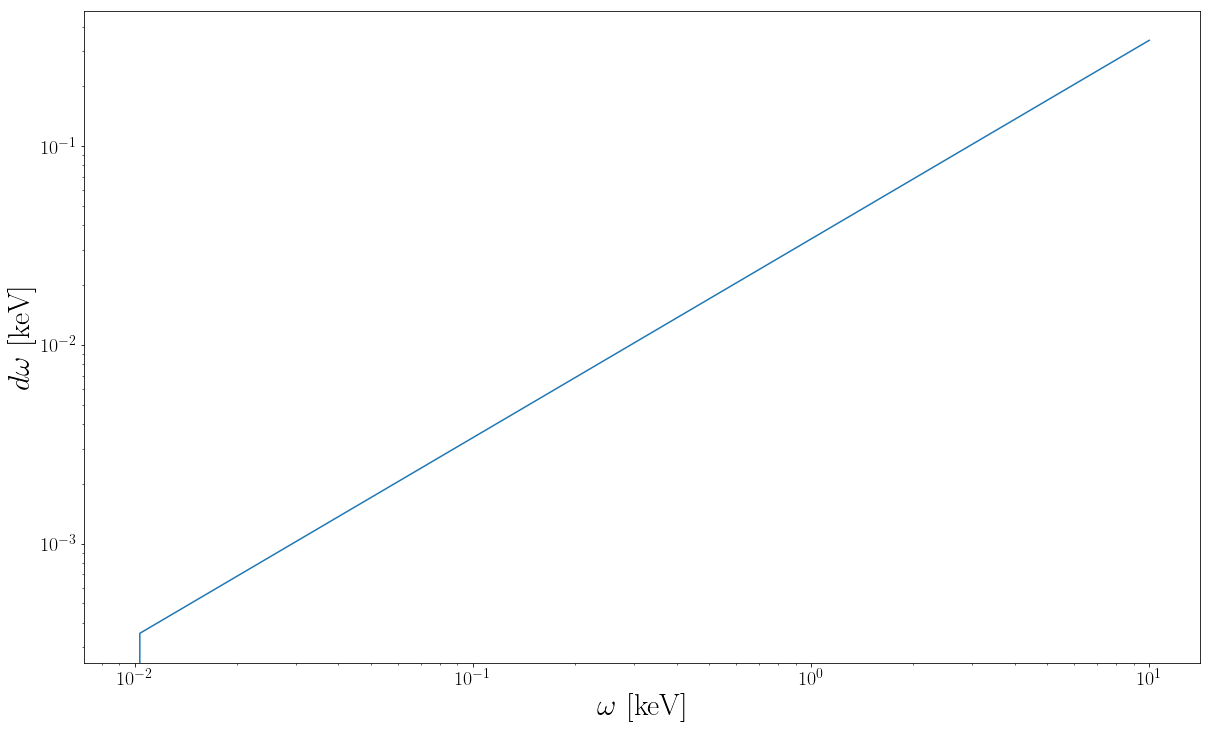

In [8]:
_,ax = plt.subplots(figsize = [20, 12])
ax.loglog(S2omega_keV, S2dOmega_keV)
plt.setp(ax.get_xticklabels(), fontsize = 20)
plt.setp(ax.get_yticklabels(), fontsize = 20)
ax.set_xlabel(r"\(\displaystyle{\omega\,\left[\textrm{keV}\right]}\)", fontsize = 30)
ax.set_ylabel(r"\(\displaystyle{d\omega\,\left[\textrm{keV}\right]}\)", fontsize = 30)
plt.show()

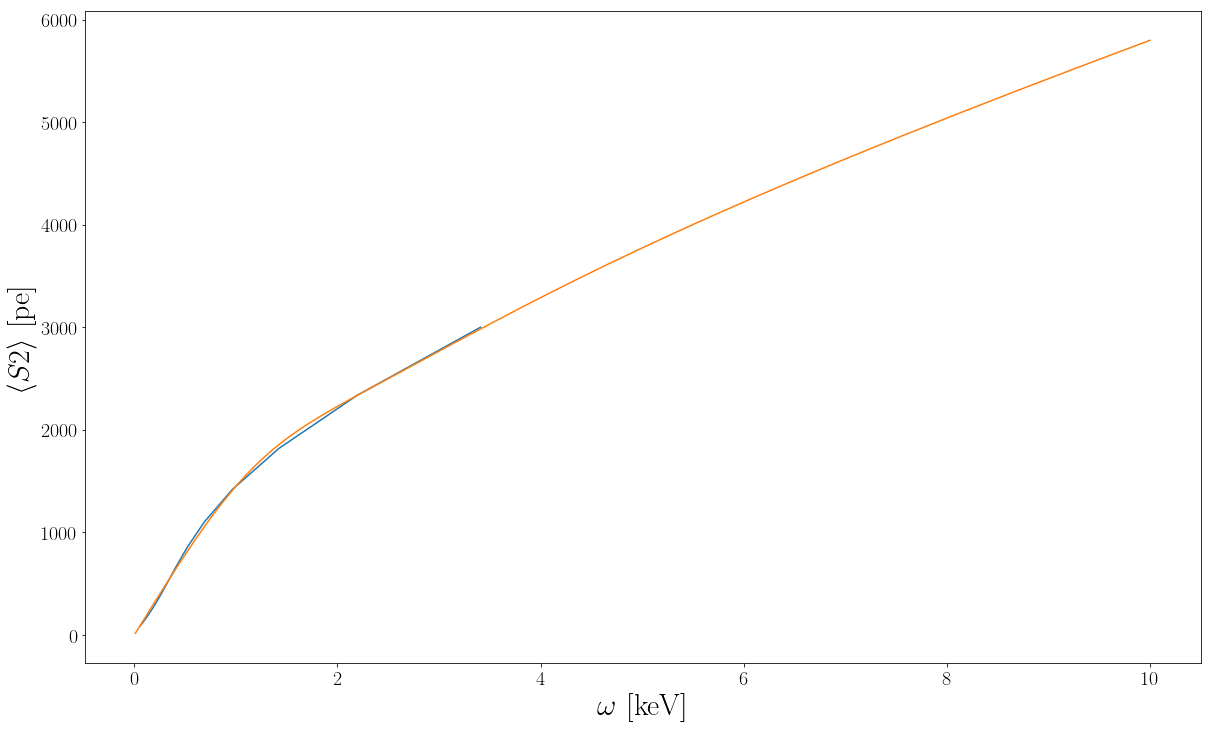

In [9]:
_,ax = plt.subplots(figsize = [20, 12])
ax.plot(XENON1TS2BinsBoundaries_keV, XENON1TS2BinsBoundaries_pe, S2omega_keV, S2ExpectationValue_pe)
plt.setp(ax.get_xticklabels(), fontsize = 20)
plt.setp(ax.get_yticklabels(), fontsize = 20)
ax.set_xlabel(r"\(\displaystyle{\omega\,\left[\textrm{keV}\right]}\)", fontsize = 30)
ax.set_ylabel(r"\(\displaystyle{\left<S2\right>\,\left[\textrm{pe}\right]}\)", fontsize = 30)
plt.show()

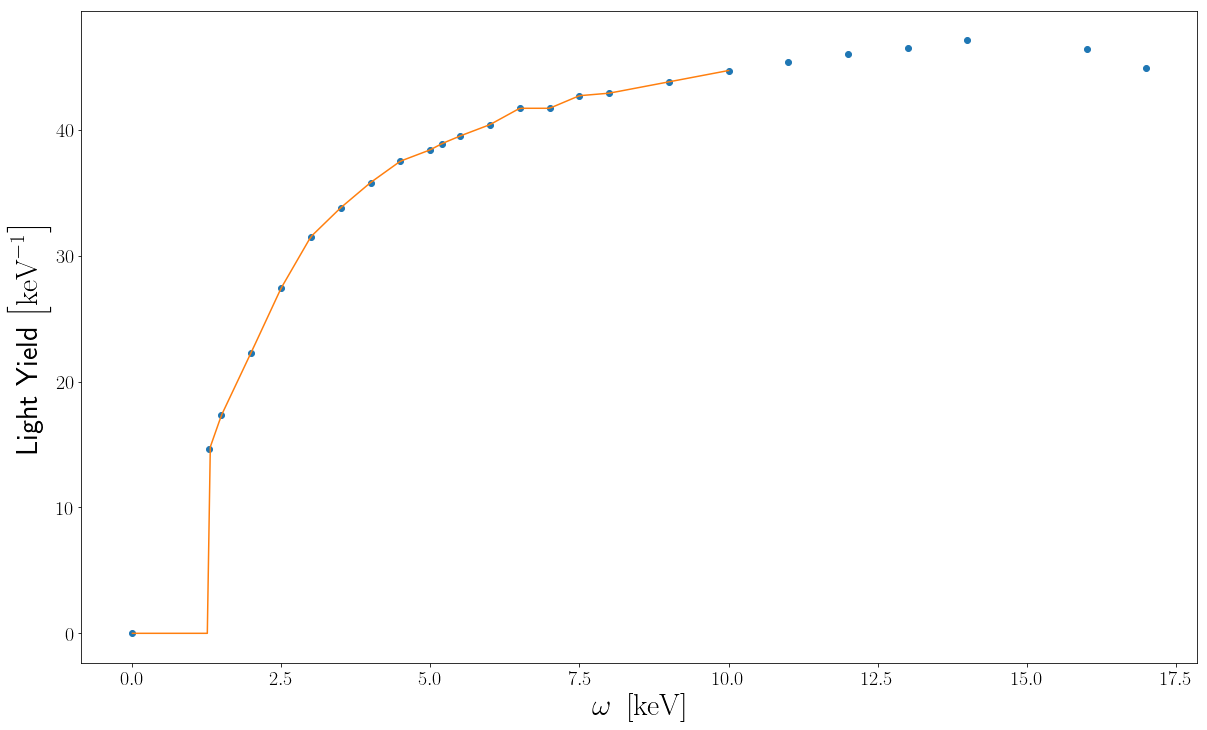

In [10]:
_,ax = plt.subplots(figsize = [20, 12])
ax.plot(LyEnergy0_keV, lightYield0_photons_keV, r"o", S1omega_keV, Ly_photons_keV)
plt.setp(ax.get_xticklabels(), fontsize = 20)
plt.setp(ax.get_yticklabels(), fontsize = 20)
ax.set_xlabel(r"$\displaystyle{\omega\ \left[\textrm{keV}\right]}$", fontsize = 30)
ax.set_ylabel(r"Light Yield $\displaystyle{\left[\textrm{keV}^{-1}\right]}$", fontsize = 30)
plt.show()

In [11]:
if(smearingDistributionString == r"Gauss"):
    _,ax = plt.subplots(figsize = [20, 12])
    ax.plot(stdEnergy0LUX_keV, photonNumberStd0LUX_photons, r"o", S1omega_keV, photonNumberStd_photons)
    plt.setp(ax.get_xticklabels(), fontsize = 20)
    plt.setp(ax.get_yticklabels(), fontsize = 20)
    ax.set_xlabel(r"$\displaystyle{\omega\ \left[\textrm{keV}\right]}$", fontsize = 30)
    ax.set_ylabel(r"$\displaystyle{\sigma_{\gamma}\ \left[\textrm{photons}\right]}$", fontsize = 30)
    plt.show()
    
    #print(r"LUXS1Sigma(1.5 keV) =", LUXS1Sigma_pe[S1omega_keV == 1.5][0])
    _,ax = plt.subplots(figsize = [20, 12])
    ax.plot(S1omega_keV, LUXS1Sigma_pe, S1omega_keV, XENON1TS1Sigma_pe)
    plt.setp(ax.get_xticklabels(), fontsize = 20)
    plt.setp(ax.get_yticklabels(), fontsize = 20)
    ax.set_xlabel(r"$\displaystyle{\omega\ \left[\textrm{keV}\right]}$", fontsize = 30)
    ax.set_ylabel(r"$\displaystyle{\sigma_{S1}\ \left[\textrm{pe}\right]}$", fontsize = 30)
    plt.show()

In [12]:
def FillF(S):
    '''
    Fill a table of values of F.
    
    Input parameters:
    -----------------
    * S - Numerical value which discribes the detection channel. "1" for S1, and "2" for S2.
    
    Output:
    -------
    A calculated table of values of F. The first axis is the energy, and the second is the solar radius.
    '''
    omega_keV = GetSomega(S)
    Fscalar   = np.zeros((omega_keV.size, numberOfRadiusGridPoints))
    yParam    = kappa_keV / np.sqrt(2 * Me_keV * T_keV)
    start     = tm.time()
    for i in range(omega_keV.size):
        Fscalar[i] = F(omega_keV[i] / T_keV, yParam)
    print(tm.time() - start)
    
    return Fscalar

# Time Consuming
# --------------
Fscalar1 = FillF(1)
Fscalar2 = FillF(2)

114.72268605232239
256.48688101768494


In [13]:
# Time Consuming
# --------------
LUXS1SmearingDistribution     = np.zeros((S1numberOfOmegaGridPoints, S1Bins_pe.size))
XENON1TS1SmearingDistribution = np.zeros((S1numberOfOmegaGridPoints, S1Bins_pe.size))
start = tm.time()
if(smearingDistributionString == r"Gauss"):
    for i in range(S1numberOfOmegaGridPoints):
        LUXS1SmearingDistribution[i]     = Gaussian(S1Bins_pe, LUXS1_pe[i], LUXS1Sigma_pe[i])
        XENON1TS1SmearingDistribution[i] = Gaussian(S1Bins_pe, XENON1TS1_pe[i], XENON1TS1Sigma_pe[i])
else:
    for i in range(S1numberOfOmegaGridPoints):
        LUXS1SmearingDistribution[i]     = Poisson(S1Bins_pe, LUXS1_pe[i])
        XENON1TS1SmearingDistribution[i] = Poisson(S1Bins_pe, XENON1TS1_pe[i])
print(tm.time() - start)

XENON1TS2SmearingDistribution = np.zeros((S2numberOfOmegaGridPoints, S2Bins_pe.size))
start = tm.time()
for i in range(S2numberOfOmegaGridPoints):
    XENON1TS2SmearingDistribution[i] = GetXENON1TEnergyInS2Bins(S2omega_keV[i])
print(tm.time() - start)

0.0072820186614990234
568.6575310230255


In [14]:
#from mpl_toolkits.mplot3d import axes3d
#import matplotlib.pyplot as plt
#
#
#fig = plt.figure()
#fig.set_size_inches(18.5, 10.5)
#ax = fig.add_subplot(111, projection='3d')
#
#MS2, MS2omega_keV = np.meshgrid(np.arange(S2Bins_pe.size), S2omega_keV)
#
#ax.plot_surface(MS2omega_keV, MS2, XENON1TS2SmearingDistribution[:,:], rstride=10, cstride=10)
#ax.set_xlabel(r"\(\omega\left[\textrm{keV}\right]\)", fontsize = 30)
#ax.set_ylabel(r"\(S2\left[\textrm{pe}\right]\)", fontsize = 30)
#ax.set_zlabel(r"\(D\)", fontsize = 30)
#plt.setp(ax.get_xticklabels(), fontsize = 20)
#plt.setp(ax.get_yticklabels(), fontsize = 20)
#plt.setp(ax.get_zticklabels(), fontsize = 20)
##ax.set(zlim = [0, 6e-3])
#plt.show()

#_,ax = plt.subplots(figsize = [20, 12])
#ax.loglog(np.arange(S2Bins_pe.size), XENON1TS2SmearingDistribution[2])
#plt.setp(ax.get_xticklabels(), fontsize = 20)
#plt.setp(ax.get_yticklabels(), fontsize = 20)
#ax.set_xlabel(r"\(S2\left[\textrm{pe}\right]\)", fontsize = 30)
#ax.set_ylabel(r"\(D\)", fontsize = 30)
#ax.set(xlim = [1e-2, 2e0], ylim = [9e-18, 1e-13])
#ax.legend(fontsize = 20)
#plt.show()

# Scalar Differential Flux - Photo-Production

In [15]:
def ScalarSolarPhotoProduction(omega_keV, omegaIndex, gee, m_keV):
    '''
    Input parameters:
    -----------------
    * omega_keV  - Energy of incoming boson.
    * omegaIndex - An identifier which identifies the scalar energy inside omega_keV.
    * gee        - Coupling to electrons.
    * m_keV      - The mass of the scalar particle.
    
    Output:
    -------
    The differential flux in units of 1/(cm^2 s keV).
    '''
    if(m_keV > omega_keV[omegaIndex]):
        return 0
    
    photonDensity = 1 / (np.exp(omega_keV[omegaIndex] / T_keV) - 1)
    betaSquared = GetBetaSquared(m_keV, omega_keV[omegaIndex])
    sigma_1_keV2 = betaSquared * alpha * gee**2 / (3 * Me_keV**2)
    
    Gamma_1_cm3keV3s = photonDensity * eDensity_1_cm3 * sigma_1_keV2 / hbar_keVs

    return differentialRateToDifferentialFlux(Gamma_1_cm3keV3s, omega_keV, omegaIndex, np.sqrt(betaSquared))

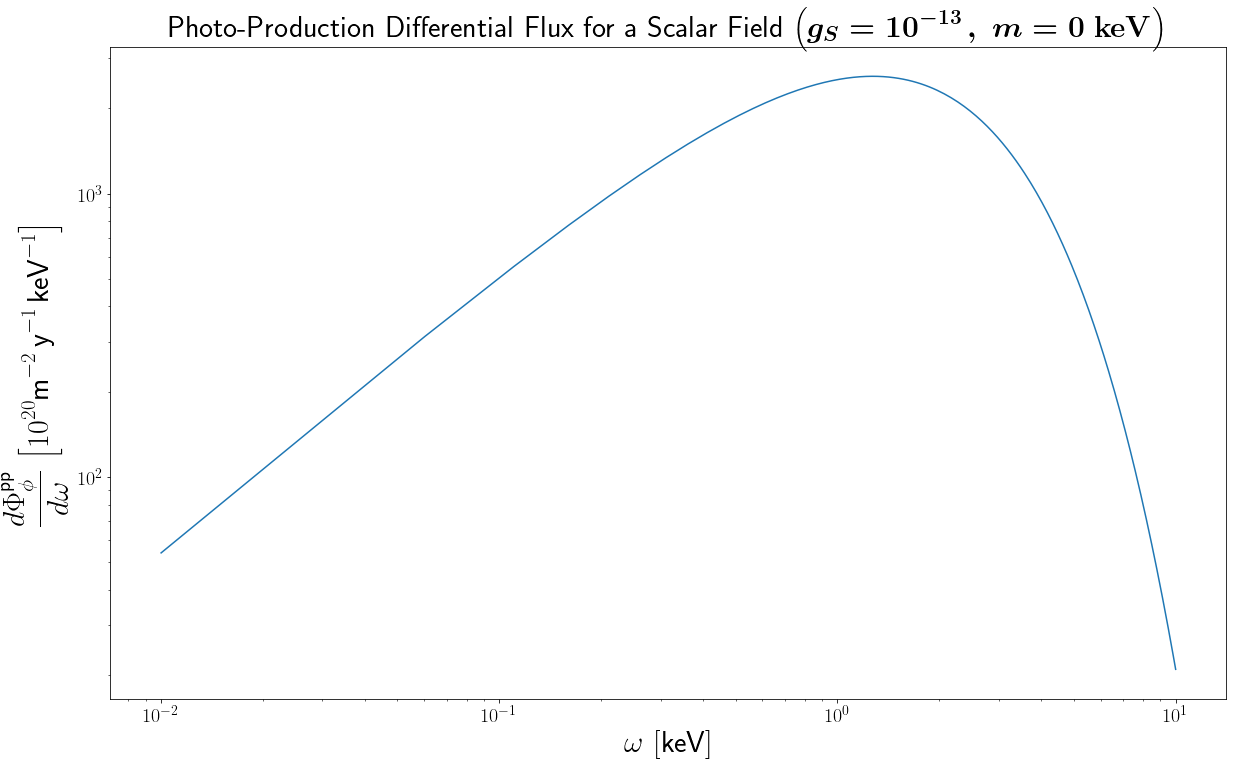

In [16]:
S             = 1
omega_keV     = GetSomega(S)
couplingPower = r"-13"
gee           = BaseTenExponentiation(couplingPower)
m_keV         = 0
SPhotoProductionFlux_1_cm2keVs = np.array([ScalarSolarPhotoProduction(omega_keV, i, gee, m_keV) \
                                                                                  for i in range(omega_keV.size)])

PlotDifferentialFlux(omega_keV,
                     SPhotoProductionFlux_1_cm2keVs,
                     r"Photo-Production",
                     r"Scalar",
                     couplingPower,
                     m_keV,
                     True,
                     True)

# Scalar Thermal Differential Flux - Bremsstrahlung

In [17]:
def ScalarSolarBremsstrahlung(omega_keV, omegaIndex, gee, m_keV):
    '''
    Input parameters:
    -----------------
    * omega_keV  - Energy of incoming boson.
    * omegaIndex - An identifier which identifies the scalar energy inside omega_keV.
    * gee        - Yukawa coupling to electrons.
    * m_keV      - The mass of the scalar particle.
    
    Output:
    -------
    The differential flux in units of 1/(cm^2 s keV).
    '''
    if(m_keV > omega_keV[omegaIndex]):
        return 0
    
    betaSquared = GetBetaSquared(m_keV, omega_keV[omegaIndex])
    
    factor = betaSquared * (alpha * gee)**2 * 8 * np.sqrt(tau) / 3
    numerator_keV3_cm3 = eDensity_1_cm3 * Z2IonDensity_keV3
    denominator_keV6s = omega_keV[omegaIndex]**3 * Me_keV**(3 / 2) * np.sqrt(T_keV) * hbar_keVs
    Gamma_1_cm3keV3s = factor * (numerator_keV3_cm3 / denominator_keV6s) \
                                                  * np.exp(- omega_keV[omegaIndex] / T_keV) * Fscalar1[omegaIndex]
    
    return differentialRateToDifferentialFlux(Gamma_1_cm3keV3s, omega_keV, omegaIndex, np.sqrt(betaSquared))

def GetPhotonGamma(omega_keV, omegaIndex, gee):
    '''
    Input parameters:
    -----------------
    * omega_keV  - Energy of incoming boson.
    * omegaIndex - An identifier which identifies the scalar energy inside omega_keV.
    * gee        - Coupling to electrons.
    
    Output:
    -------
    The production and thermal equilibrium differential rates of photon, arising due to bremsstrahlung process.
    '''
    factor = alpha**3 * 16 * tau**(3 / 2) / 3
    numerator_keV3_cm3 = eDensity_1_cm3 * Z2IonDensity_keV3
    denominator_keV6s = omega_keV[omegaIndex]**3 * Me_keV**(3 / 2) * np.sqrt(T_keV) * hbar_keVs
    auxPhotonGamma_1_cm3keV3s = factor * (numerator_keV3_cm3 / denominator_keV6s) * Fscalar2[omegaIndex]
    photonGammaProduction_1_cm3keV3s = auxPhotonGamma_1_cm3keV3s * np.exp(- omega_keV[omegaIndex] / T_keV)
    photonGammaTermalEquilibrium_keV = auxPhotonGamma_1_cm3keV3s * hbar_keVs * (hbar_keVs * c_cm_s)**3 \
                                                                   * (1 - np.exp(- omega_keV[omegaIndex] / T_keV))
    
    return (photonGammaProduction_1_cm3keV3s, photonGammaTermalEquilibrium_keV)

def ScalarSolarThermalBremsstrahlung(omega_keV, omegaIndex, gee, m_keV):
    '''
    Input parameters:
    -----------------
    * omega_keV  - Energy of incoming boson.
    * omegaIndex - An identifier which identifies the scalar energy inside omega_keV.
    * gee        - Coupling to electrons.
    * m_keV      - The mass of the scalar particle.
    
    Output:
    -------
    The differential flux, including plasma mixing effects, in units of 1/(cm^2 s keV).
    '''
    if(m_keV > omega_keV[omegaIndex]):
        return 0
    
    photonGammaProduction_1_cm3keV3s, photonGammaTermalEquilibrium_keV = GetPhotonGamma(omega_keV,
                                                                                        omegaIndex,
                                                                                        gee)
    betaSquared = GetBetaSquared(m_keV, omega_keV[omegaIndex])
    
    Gamma_1_cm3keV3s = betaSquared * (gee**2 / (2 * tau * alpha)) * photonGammaProduction_1_cm3keV3s
    
    resonanceTerm = (1 - plasmaFrequencySquared_keV2 / omega_keV[omegaIndex]**2)**2
    denominator = resonanceTerm + (photonGammaTermalEquilibrium_keV / omega_keV[omegaIndex])**2
    Gamma_1_cm3keV3s = Gamma_1_cm3keV3s / denominator
    
    return differentialRateToDifferentialFlux(Gamma_1_cm3keV3s, omega_keV, omegaIndex, np.sqrt(betaSquared))

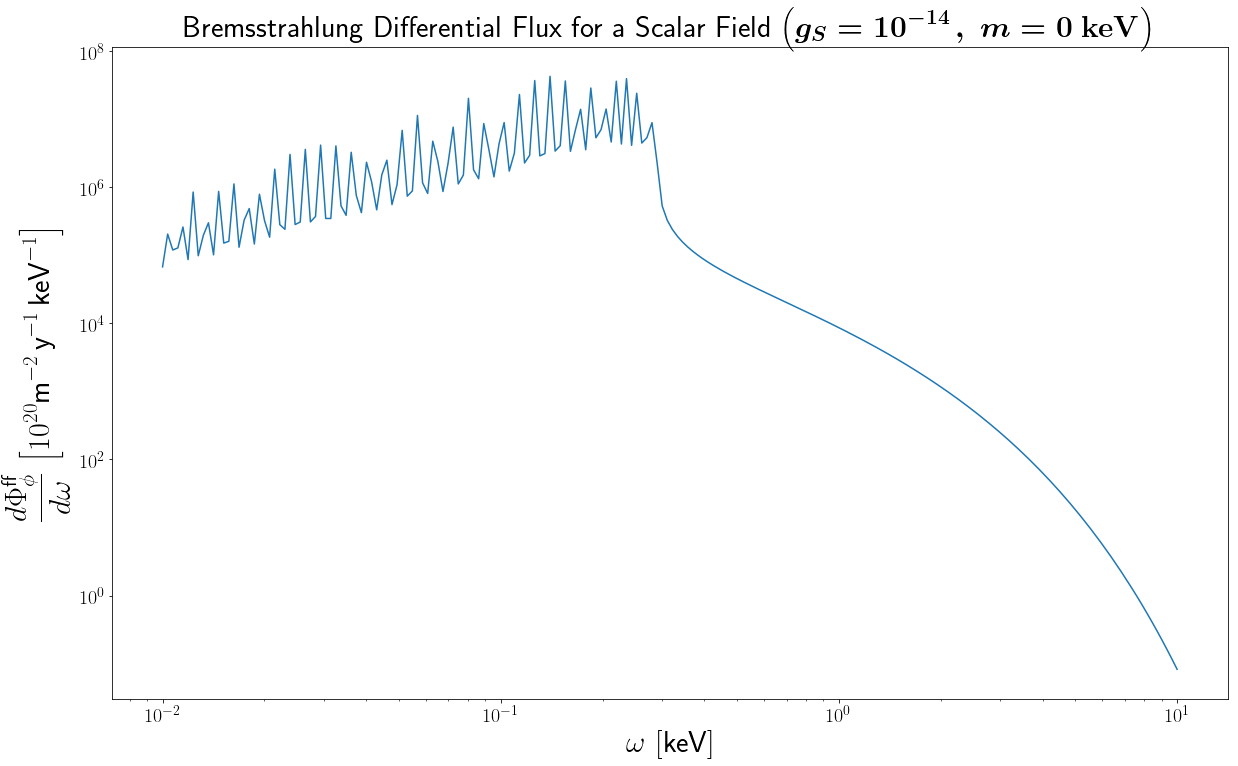

In [18]:
S             = 2
omega_keV     = GetSomega(S)
couplingPower = r"-14"
gee           = BaseTenExponentiation(couplingPower)
m_keV         = 0
SBremsstrahlungThermalFlux_1_cm2keVs = np.array([ScalarSolarThermalBremsstrahlung(omega_keV, i, gee, m_keV) \
                                                                                  for i in range(omega_keV.size)])

PlotDifferentialFlux(omega_keV,
                     SBremsstrahlungThermalFlux_1_cm2keVs,
                     r"Bremsstrahlung",
                     r"Scalar",
                     couplingPower,
                     m_keV,
                     True,
                     True)

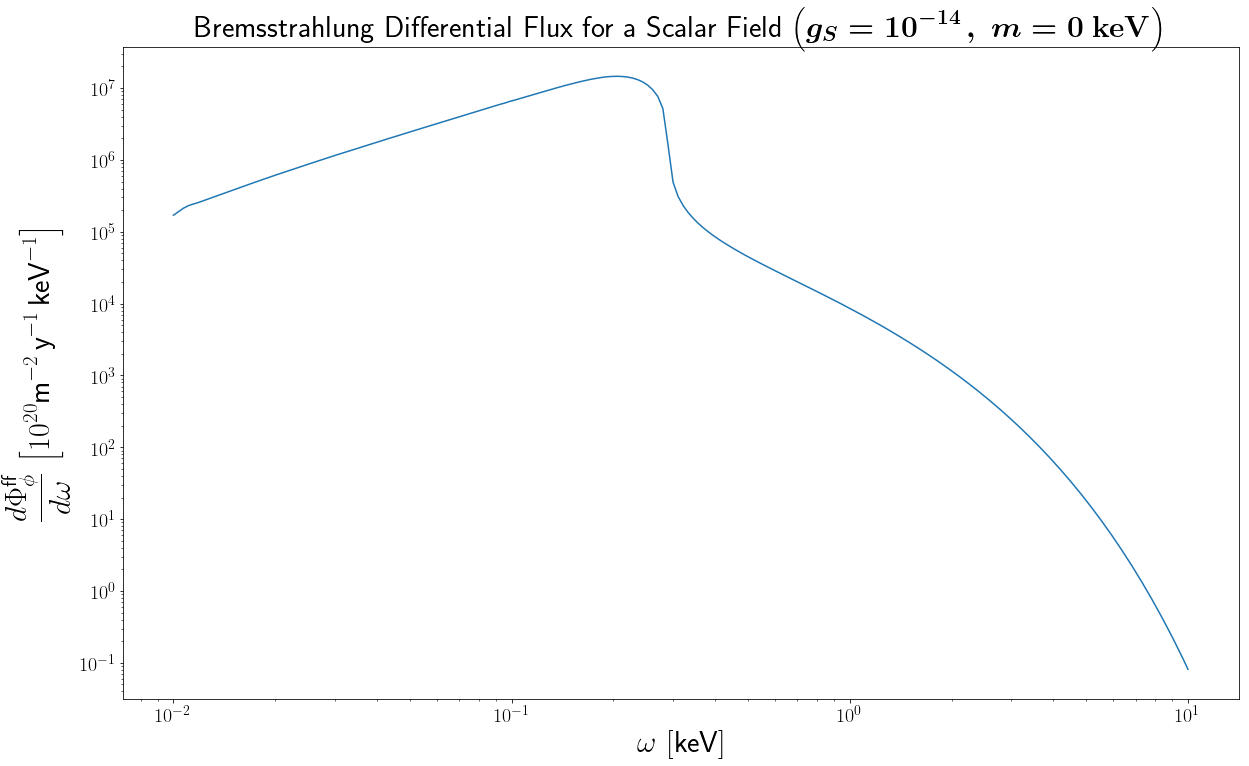

In [19]:
S             = 2
omega_keV     = GetSomega(S)
couplingPower = r"-14"
gee           = BaseTenExponentiation(couplingPower)
m_keV         = 0

gSquaredBetaCubed = gee**2 * GetBetaCubedArray(m_keV, omega_keV)
SBremsstrahlungThermalFlux_1_cm2keVs = gSquaredBetaCubed * scalarBremsstrahlungFlux_1_cm2keVs

PlotDifferentialFlux(omega_keV,
                     SBremsstrahlungThermalFlux_1_cm2keVs,
                     r"Bremsstrahlung",
                     r"Scalar",
                     couplingPower,
                     m_keV,
                     True,
                     True)

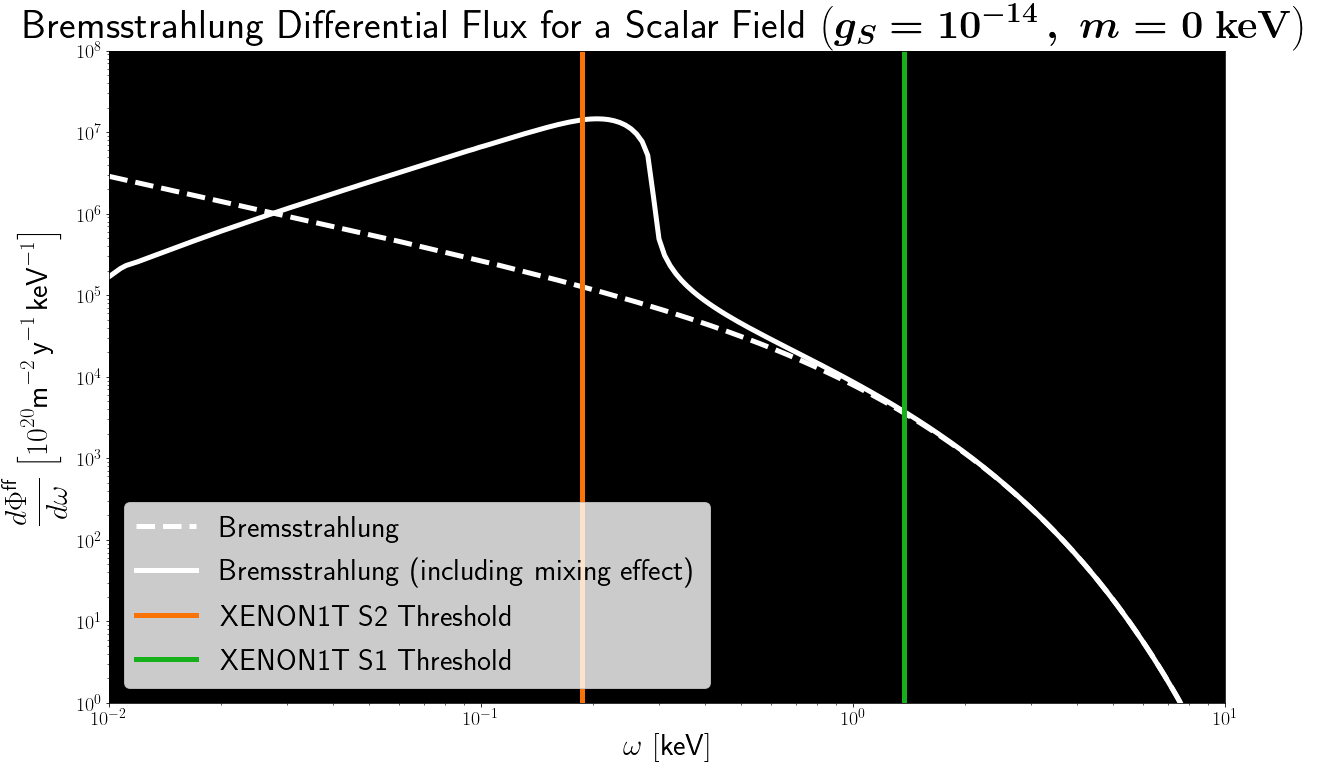

In [20]:
conversion_scm2_ym2 = year_s_y / (10**20 * const.centi**2)

SBremsstrahlungThermalFlux_10p20_m2keVy = conversion_scm2_ym2 * SBremsstrahlungThermalFlux_1_cm2keVs
SBremsstrahlungFlux_10p20_m2keVy        = conversion_scm2_ym2 \
                          * np.array([ScalarSolarBremsstrahlung(S1omega_keV,
                                                                i,
                                                                gee,
                                                                m_keV) for i in range(S1numberOfOmegaGridPoints)])

title  = MakeTitle(r"Bremsstrahlung Differential Flux", r"Scalar", couplingPower, m_keV)
xlabel = r"$\displaystyle{\omega\,\left[\text{keV}\right]}$"
ylabel = r"$\displaystyle{\frac{d\Phi^{\text{ff}}}{d\omega}\," \
                                          + r"\left[10^{20}\text{m}^{-2}\,\text{y}^{-1}\,\text{keV}^{-1}\right]}$"

_,ax = plt.subplots(figsize = [20, 12])
ax.loglog(S1omega_keV,
          SBremsstrahlungFlux_10p20_m2keVy,
          color = r"white",
          linestyle = r"dashed",
          linewidth = 5,
          label = r"Bremsstrahlung")
ax.loglog(S2omega_keV,
          SBremsstrahlungThermalFlux_10p20_m2keVy,
          color = r"white",
          linewidth = 5,
          label = r"Bremsstrahlung (including mixing effect)")
ax.axvline(S2energyIRCutoff_keV, linewidth = 5, label = r"XENON1T S2 Threshold", color = r"xkcd:orange")
ax.axvline(S1omega_keV[27], linewidth = 5, label = r"XENON1T S1 Threshold", color = r"xkcd:green")
plt.setp(ax.get_xticklabels(), fontsize = 20)
plt.setp(ax.get_yticklabels(), fontsize = 20)
ax.set_title(title, fontweight = r"bold", size = 40)
ax.set_xlabel(xlabel, fontsize = 30)
ax.set_ylabel(ylabel, fontsize = 30)
ax.set(xlim = [1e-2, 1e1], ylim = [1e0, 1e8])
ax.legend(fontsize = 30)
ax.set_facecolor(r"xkcd:black")
plt.show()

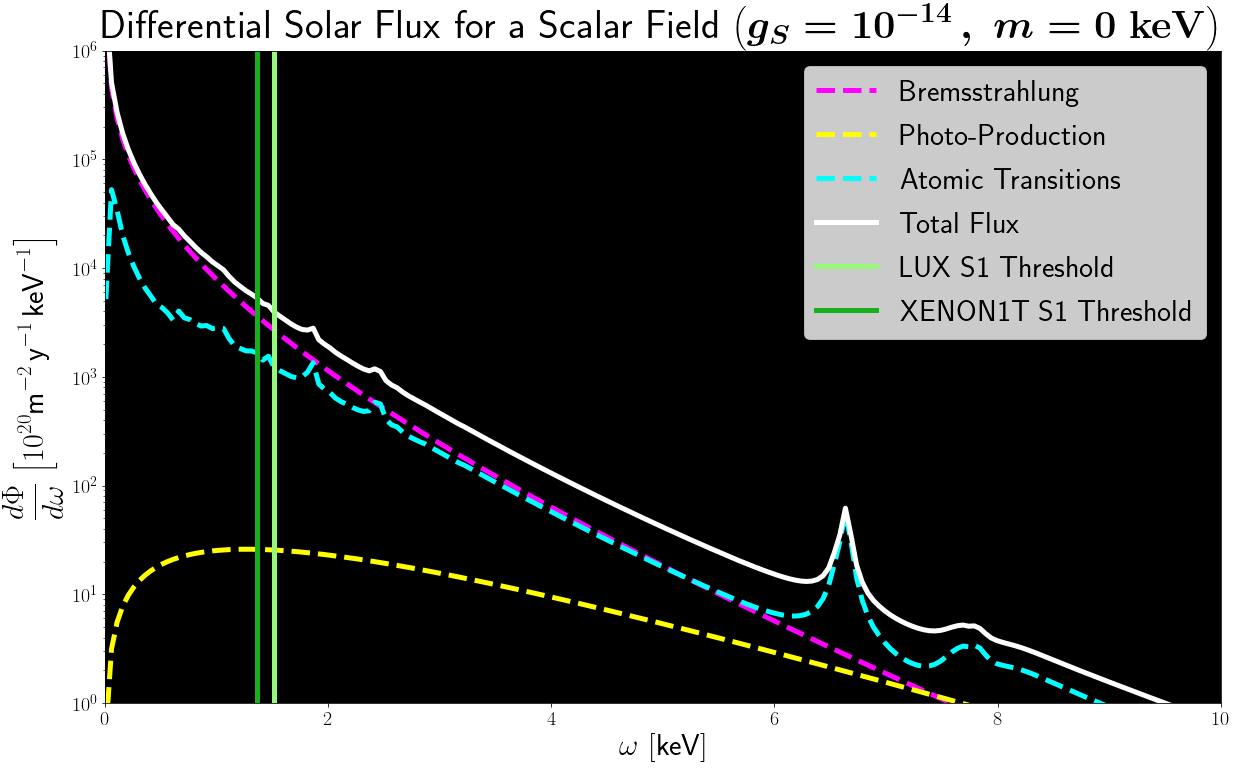

In [21]:
S                   = 1
omega_keV           = GetSomega(S)
couplingPower       = r"-14"
gee                 = BaseTenExponentiation(couplingPower)
m_keV               = 0
betaCubed           = GetBetaCubedArray(m_keV, omega_keV)
conversion_scm2_ym2 = year_s_y / (10**20 * const.centi**2)

bremsstrahlungSolarFlux_10p20_m2keVy    = conversion_scm2_ym2 \
                  * np.array([ScalarSolarBremsstrahlung(omega_keV, i, gee, m_keV) for i in range(omega_keV.size)])
photoProductionSolarFlux_10p20_m2keVy   = conversion_scm2_ym2 \
                  * np.array([ScalarSolarPhotoProduction(omega_keV, i,gee, m_keV) for i in range(omega_keV.size)])
atomicTransitionsSolarFlux_10p20_m2keVy = (conversion_scm2_ym2 * gee**2 * betaCubed / (2 * tau * alpha)) \
                                                                                 * atomicTransitionsFlux_1_cm2keVs

title = MakeTitle(r"Differential Solar Flux", r"Scalar", couplingPower, m_keV)
xlabel = r"$\displaystyle{\omega\,\left[\text{keV}\right]}$"
ylabel = r"$\displaystyle{\frac{d\Phi}{d\omega}\," \
                                          + r"\left[10^{20}\text{m}^{-2}\,\text{y}^{-1}\,\text{keV}^{-1}\right]}$"

_,ax = plt.subplots(figsize = [20, 12])
ax.semilogy(omega_keV,
            bremsstrahlungSolarFlux_10p20_m2keVy,
            color = r"fuchsia",
            linestyle = r"dashed",
            linewidth = 5,
            label = r"Bremsstrahlung")
ax.semilogy(omega_keV,
            photoProductionSolarFlux_10p20_m2keVy,
            color = r"yellow",
            linestyle = r"dashed",
            linewidth = 5,
            label = r"Photo-Production")
ax.semilogy(omega_keV,
            atomicTransitionsSolarFlux_10p20_m2keVy,
            color = r"cyan",
            linestyle = r"dashed",
            linewidth = 5,
            label = r"Atomic Transitions")
ax.semilogy(omega_keV,
            bremsstrahlungSolarFlux_10p20_m2keVy \
            + photoProductionSolarFlux_10p20_m2keVy \
            + atomicTransitionsSolarFlux_10p20_m2keVy,
            color = r"white",
            linewidth = 5,
            label = r"Total Flux")
ax.axvline(S1omega_keV[30], linewidth = 5, label = r"LUX S1 Threshold", color = r"xkcd:light green")
ax.axvline(S1omega_keV[27], linewidth = 5, label = r"XENON1T S1 Threshold", color = r"xkcd:green")
plt.setp(ax.get_xticklabels(), fontsize = 20)
plt.setp(ax.get_yticklabels(), fontsize = 20)
ax.set_title(title, fontweight = r"bold", size = 40)
ax.set_xlabel(xlabel, fontsize = 30)
ax.set_ylabel(ylabel, fontsize = 30)
ax.set(xlim = [0, 10], ylim = [1e0, 1e6])
ax.legend(fontsize = 30)
ax.set_facecolor(r"xkcd:black")
plt.show()

# Scalar-Electric Cross-Section

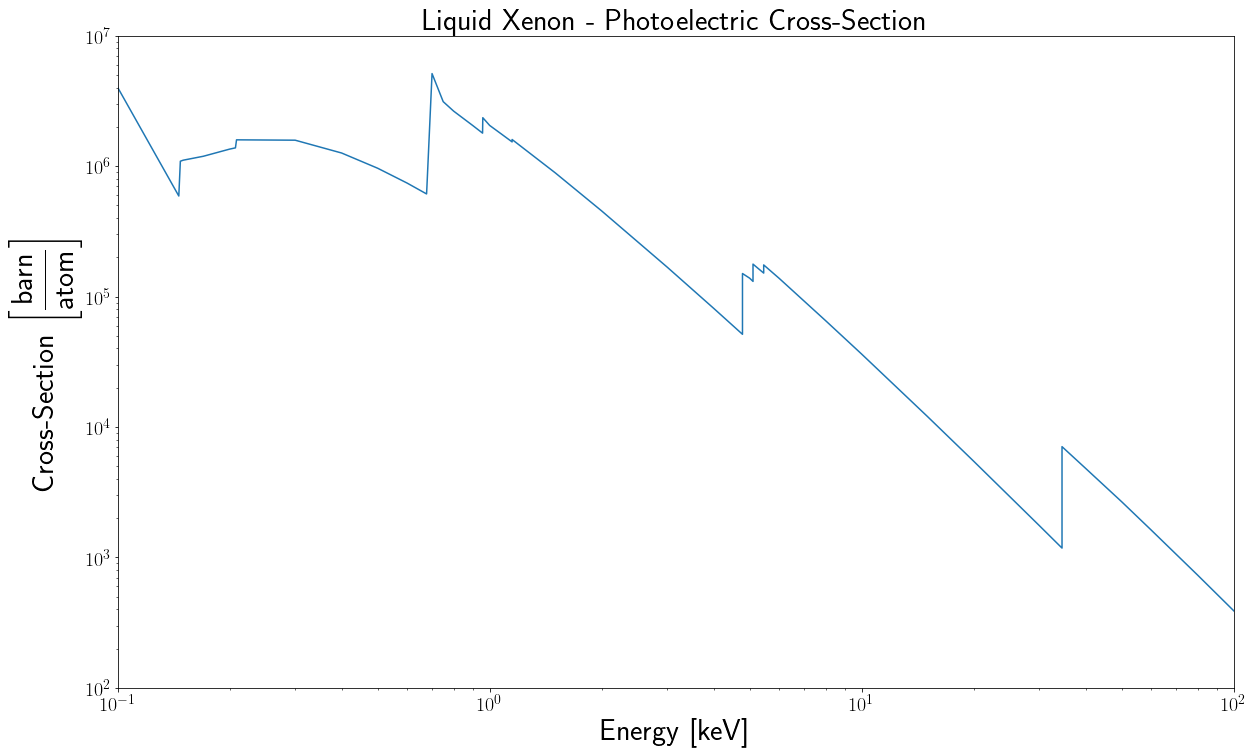

In [22]:
_,ax = plt.subplots(figsize = [20, 12])
ax.loglog(XePEXs[:, 0], XePEXs[:, 1])
ax.set(xlim = [1e-1, 1e2], ylim = [1e2, 1e7])
plt.setp(ax.get_xticklabels(), fontsize = 20)
plt.setp(ax.get_yticklabels(), fontsize = 20)
ax.set_title(r"Liquid Xenon - Photoelectric Cross-Section", fontweight = r"bold", size = 30)
ax.set_xlabel(r"Energy [keV]", fontsize = 30)
ax.set_ylabel(r"Cross-Section $\displaystyle{\left[\frac{\text{barn}}{\text{atom}}\right]}$", fontsize = 30)
plt.show()

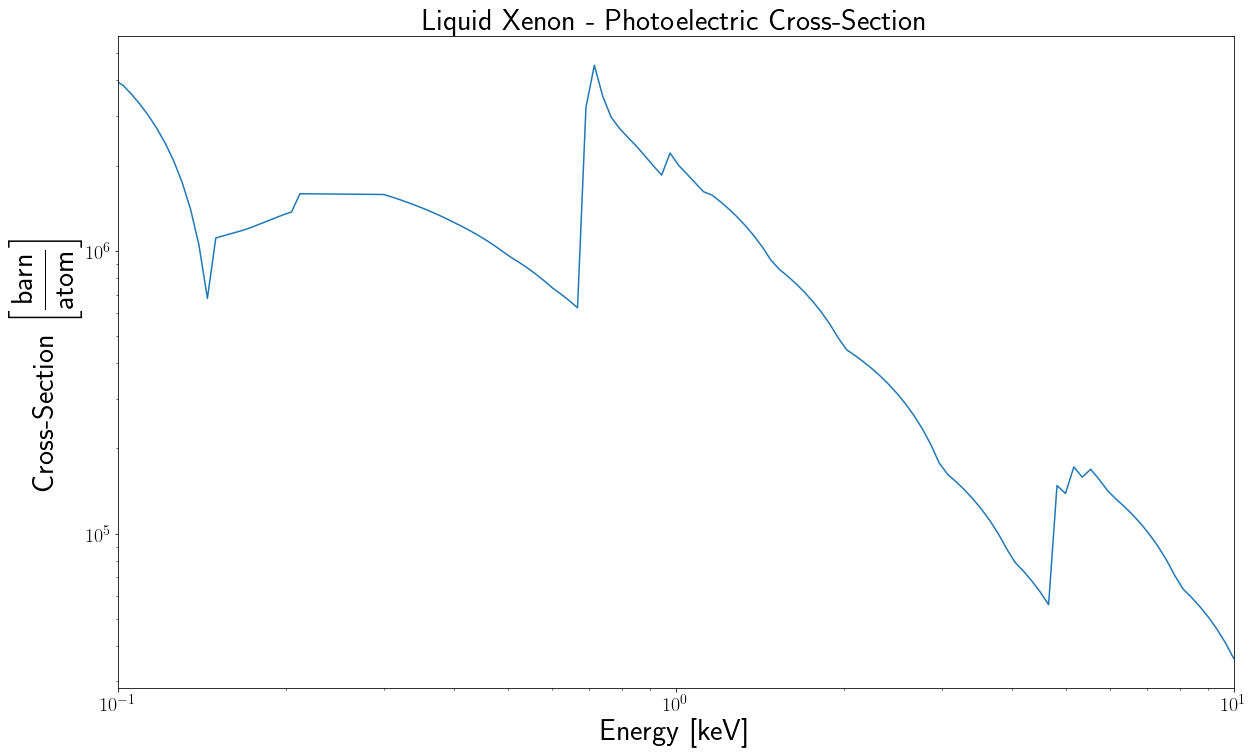

In [23]:
_,ax = plt.subplots(figsize = [20, 12])
ax.loglog(S2omega_keV, xenonPhotoelectricCrossSection2_cm2_atom / const.pico**2)
ax.set(xlim = [1e-1, 1e1])#, ylim = [1e2, 1e7])
plt.setp(ax.get_xticklabels(), fontsize = 20)
plt.setp(ax.get_yticklabels(), fontsize = 20)
ax.set_title(r"Liquid Xenon - Photoelectric Cross-Section", fontweight = r"bold", size = 30)
ax.set_xlabel(r"Energy [keV]", fontsize = 30)
ax.set_ylabel(r"Cross-Section $\displaystyle{\left[\frac{\text{barn}}{\text{atom}}\right]}$", fontsize = 30)
plt.show()

In [24]:
def BremsstrahlungPhotoProductionSolarFlux(omega_keV, omegaIndex, gee, m_keV, bosonType):
    '''
    Returns the solar flux arising from bremsstrahlung and photo-production channels, without including mixing
    effects.
    
    Input parameters:
    -----------------
    * omega_keV  - Energy of incoming boson.
    * omegaIndex - An identifier which identifies the scalar energy inside omega_keV.
    * gee        - Coupling of the boson to electrons.
    * bosonType  - A string, describing the nature of the boson. Supported values are: {Scalar}.
    * m_keV      - The mass of the particle.
    
    Output:
    -------
    Differential solar flux, coming from bremsstrahlung and photo-production processes only, in units of
    [1 / (cm^2 keV s)].
    '''
    if(bosonType == r"Scalar"):
        return ScalarSolarBremsstrahlung(omega_keV, omegaIndex, gee, m_keV) \
                                                  + ScalarSolarPhotoProduction(omega_keV, omegaIndex, gee, m_keV)
    else:
        PrintUnknownBosonType(bosonType, r"BremsstrahlungPhotoProductionSolarFlux")
        return

def SolarRate(S, gee, m_keV, bosonType):
    '''
    Input parameters:
    -----------------
    * S         - Numerical value which discribes the detection channel. "1" for S1, and "2" for S2.
    * gee       - Coupling of the boson to electrons.
    * bosonType - A string, describing the nature of the boson. Supported values are: {Scalar} for 'S = 1', and
                  {Scalar} for 'S = 2'.
    * m_keV     - The mass of the particle.
    
    Output:
    -------
    Differential rate in liquid Xenon, in units of 1 / (ton year keV)
    '''
    conversion                   = gee**2 / (2 * tau * alpha) # Conversion factor for scalar and vector.
                                                              # TODO: Check if there is no factor of 2 missing
                                                              # for the scalar.
    omega_keV                    = GetSomega(S)
    betaSquared                  = GetBetaSquaredArray(m_keV, omega_keV)
    beta                         = np.sqrt(betaSquared)
    betaCubed                    = GetBetaCubedArray(m_keV, omega_keV)
    
    mixing = False
    if(S == 1):
        if(bosonType == r"Scalar"):
            differentialFlux_1_cm2keVs = np.array([BremsstrahlungPhotoProductionSolarFlux(omega_keV,
                                                                                          i,
                                                                                          gee,
                                                                                          m_keV,
                                                                                          bosonType) \
                                                                       for i in range(omega_keV.size)])
            differentialFlux_1_cm2keVs = differentialFlux_1_cm2keVs \
                                                     + atomicTransitionsFlux_1_cm2keVs * conversion * betaCubed
        else:
            PrintUnknownBosonType(bosonType, r"SolarRater", S)
            return
        bosonElectricCrossSection_cm2_atom = xenonPhotoelectricCrossSection1_cm2_atom * conversion * beta
    elif(S == 2):
        mixing = True
        if(bosonType == r"Scalar"):
            gSquaredBetaCubed = gee**2 * betaCubed
            differentialFlux_1_cm2keVs = gSquaredBetaCubed * scalarBremsstrahlungFlux_1_cm2keVs
        else:
            PrintUnknownBosonType(bosonType, r"SolarRate", S)
            return
        bosonElectricCrossSection_cm2_atom = xenonPhotoelectricCrossSection2_cm2_atom * conversion * beta
    else:
        PrintUnknownS(S, r"SolarRate")
        return
    
    solarRate_1_MgykeV = bosonElectricCrossSection_cm2_atom * differentialFlux_1_cm2keVs \
                                                                                      * XenonAtomsInMg * year_s_y
    if(mixing):
        energyIRCutoff_keV = S2energyIRCutoff_keV
    else:
        energyIRCutoff_keV = S1energyIRCutoff_keV
    
    solarRate_1_MgykeV[omega_keV < energyIRCutoff_keV] = 0
    return solarRate_1_MgykeV

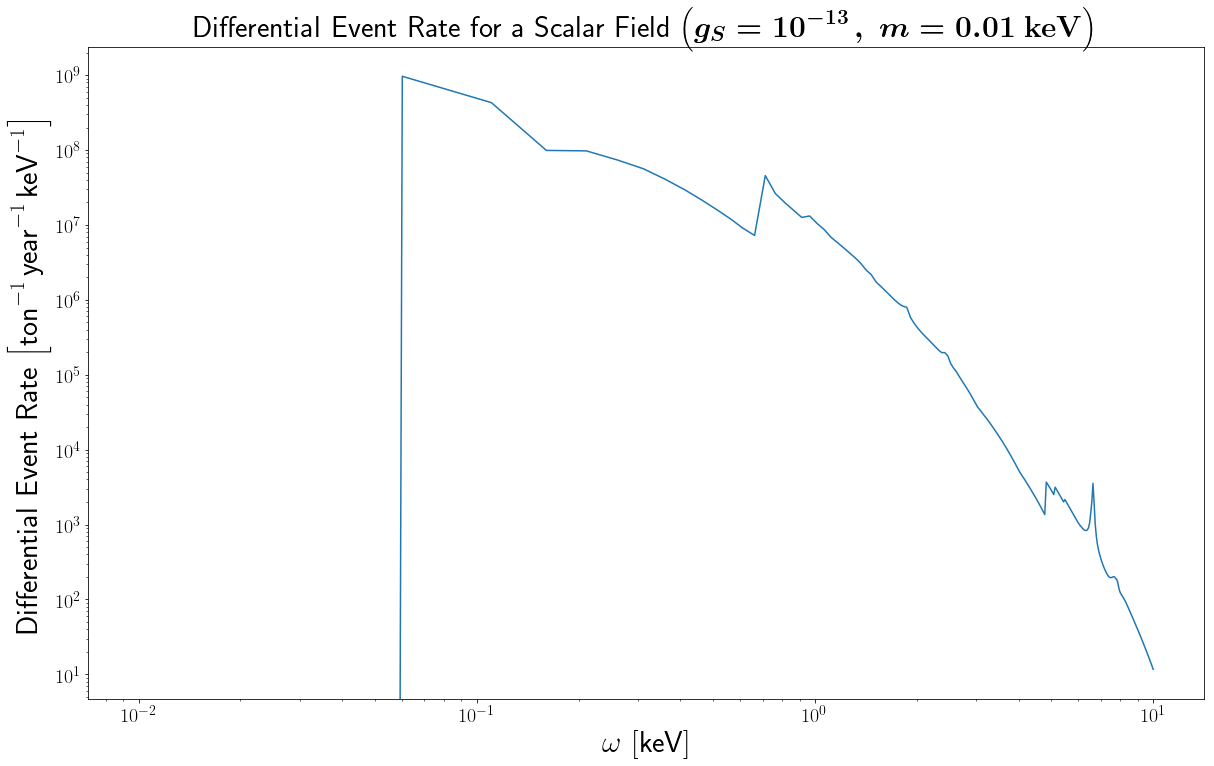

In [25]:
S              = 1
couplingPower  = r"-13"
m_keV          = 1e-2
bosonType      = r"Scalar"
physicalObject = r"Differential Event Rate"
rate_1_MgykeV  = SolarRate(S, BaseTenExponentiation(couplingPower), m_keV, bosonType)
title  = MakeTitle(physicalObject, bosonType, couplingPower, m_keV)
xlabel = r"$\displaystyle{\omega\,\left[\text{keV}\right]}$"
ylabel = physicalObject + r" $\displaystyle{\left[\text{ton}^{-1}\,\text{year}^{-1}\,\text{keV}^{-1}\right]}$"
MakePlot(S1omega_keV, rate_1_MgykeV, title, xlabel, ylabel, True)

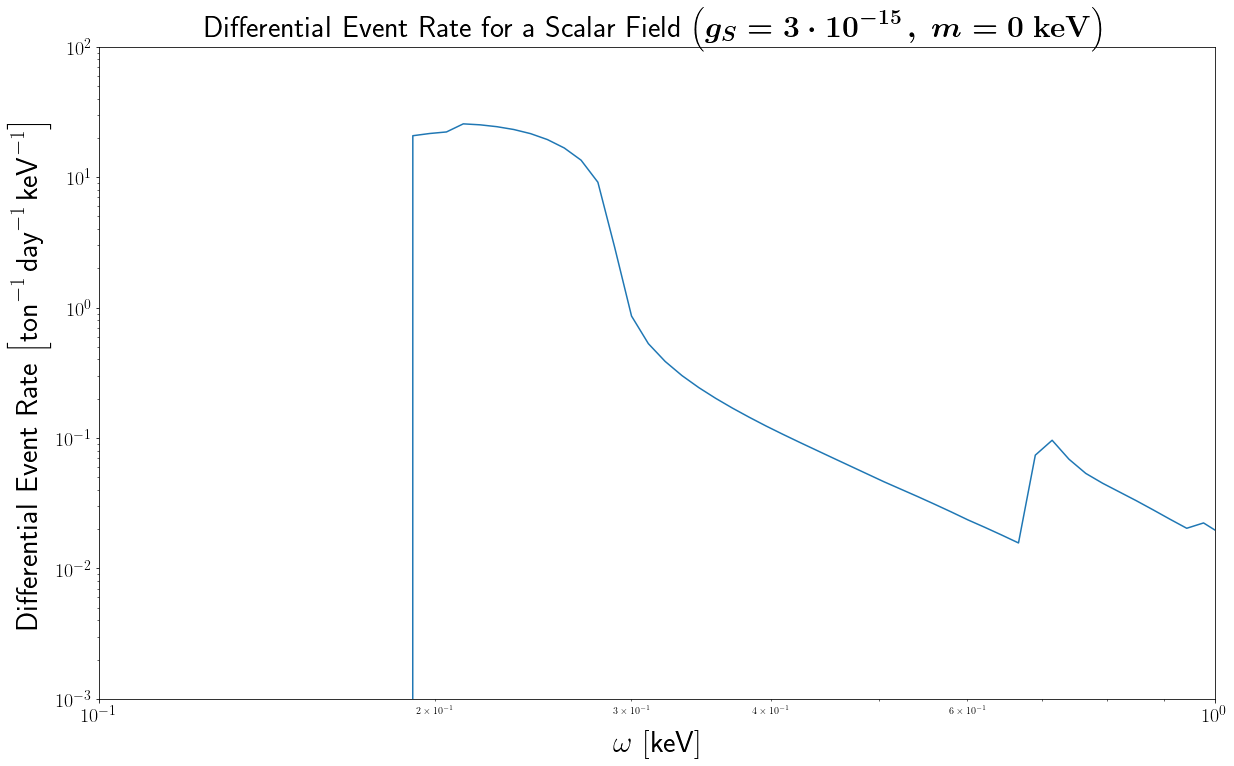

In [26]:
S              = 2
couplingPower  = r"-15"
coefficient    = 3
gee            = coefficient * BaseTenExponentiation(couplingPower)
m_keV          = 0
bosonType      = r"Scalar"
physicalObject = r"Differential Event Rate"
rate_1_MgdkeV  = SolarRate(S, gee, m_keV, bosonType) * day_s_d / year_s_y
title  = MakeTitle(physicalObject, bosonType, couplingPower, m_keV, coefficient)
xlabel = r"$\displaystyle{\omega\,\left[\text{keV}\right]}$"
ylabel = physicalObject + r" $\displaystyle{\left[\text{ton}^{-1}\,\text{day}^{-1}\,\text{keV}^{-1}\right]}$"
_,ax = plt.subplots(figsize = [20, 12])
ax.loglog(S2omega_keV, rate_1_MgdkeV)
plt.setp(ax.get_xticklabels(), fontsize = 20)
plt.setp(ax.get_yticklabels(), fontsize = 20)
ax.set_title(title, fontweight = r"bold", size = 30)
ax.set_xlabel(xlabel, fontsize = 30)
ax.set_ylabel(ylabel, fontsize = 30)
ax.set(xlim = [1e-1, 1e0], ylim = [1e-3, 1e2])
plt.show()

In [27]:
def MassiveProfileLikelihood(gee, unitEventDensity_1_keV, experiment, S, data, background):
    '''
    Calculates the profile likelihood.
    Currently, LUX, XENON1T and XENONnT are assumed to use only S1 data, while XENON100 is assumed to use only
    S2 data.
    
    Input parameters:
    -----------------
    * gee            - Coupling of the boson to electrons.
    * experiment     - A string, identifying the experiment. Supported values are: {LUX, XENON1T, XENONnT}.
    
    Output:
    -------
    The calculated profile likelihood. If getSignalCount equals to True, also the total number of signal events.
    '''
    summedSignal = GetSignalInSBins(gee**4 * unitEventDensity_1_keV, experiment, S)
    # Ignore first two bins - S2 cutoff.
    if(S == 2 and experiment == r"XENON1T"):
        summedSignal = summedSignal[2:]
    return 2 * sum(summedSignal + background - data * np.log(summedSignal + background))

def MassiveLikelihood(gee, unitEventDensity_1_keV, experiment, S, data, background):
    '''
    Calculates the profile likelihood.
    Currently, LUX, XENON1T and XENONnT are assumed to use only S1 data, while XENON100 is assumed to use only
    S2 data.
    
    Input parameters:
    -----------------
    * gee            - Coupling of the boson to electrons.
    * experiment     - A string, identifying the experiment. Supported values are: {LUX, XENON1T, XENONnT}.
    
    Output:
    -------
    The calculated profile likelihood. If getSignalCount equals to True, also the total number of signal events.
    '''
    summedSignal = GetSignalInSBins(gee**4 * unitEventDensity_1_keV, experiment, S)
    # Ignore first two bins - S2 cutoff.
    if(S == 2 and experiment == r"XENON1T"):
        summedSignal = summedSignal[2:]
    return np.prod(- summedSignal - background + data * np.log(summedSignal + background) \
                                                                                       - np.log(factorial(data)))

def MassiveMinusLikelihood(gee, unitEventDensity_1_keV, experiment, S, data, background):
    '''
    Calculates the profile likelihood.
    Currently, LUX, XENON1T and XENONnT are assumed to use only S1 data, while XENON100 is assumed to use only
    S2 data.
    
    Input parameters:
    -----------------
    * gee            - Coupling of the boson to electrons.
    * experiment     - A string, identifying the experiment. Supported values are: {LUX, XENON1T, XENONnT}.
    
    Output:
    -------
    The calculated profile likelihood. If getSignalCount equals to True, also the total number of signal events.
    '''
    return - MassiveLikelihood(gee, unitEventDensity_1_keV, experiment, S, data, background)

def GetLimit1(PL, g, gPLMin):
    minPoint = sum(g < gPLMin)
    if(minPoint == g.size): 
        return -1 # Failure. Try again by increasing gMax.
    limit = np.interp(magicalLikelihoodNumber, PL[minPoint:], g[minPoint:]) # This is done for the rare case
                                                                            # where the interpolation region is
                                                                            # for a multi-valued function.
    if(limit >= g[-1]):
        return -1 # Failure. Try again by increasing gMax.
    return limit

def GetLimit2(PL, g):
    L                = np.exp(- PL / 2)
    normalizedL      = L / simps(L, g)
    partialIntegrals = np.zeros(normalizedL.size)
    for i in range(normalizedL.size):
        partialIntegrals[i] = simps(normalizedL[:i + 1], g[:i + 1])
    
    # This mathod is valid only when g[0] = 0.
    return np.interp(0.9, partialIntegrals, g)

def GetLimit2Likelihood(g, unitEventDensity_1_keV, experiment, S, data, background):
    maxLikelihoodObject = minimize(MassiveMinusLikelihood,
                                   np.mean((g[0], g[-1])),
                                   (unitEventDensity, experiment, S, data, background,),
                                   tol = 1e-20,
                                   method = r"Nelder-Mead")
    gPLMax              = maxLikelihoodObject.x[0]
    L                   = np.array([MassiveLikelihood(gg,
                                                      unitEventDensity_1_keV,
                                                      experiment,
                                                      S,
                                                      data,
                                                      background) for gg in g])
    normalizedL         = L / simps(L, g)
    partialIntegrals    = np.zeros(normalizedL.size)
    for i in range(normalizedL.size):
        partialIntegrals[i] = simps(normalizedL[:i + 1], g[:i + 1])
    
    limit               = np.interp(0.9, partialIntegrals, g)
    if(limit == g[-1]):
        limit = 1 # Arbitrary "large" number. Usefull when don't want to calculate more than needed in the plot.
    return (limit, L)

def GetLikelihoodParameters(gMin,
                            gMax,
                            gPLMin,
                            unitEventDensity_1_keV,
                            experiment,
                            S,
                            data,
                            background,
                            gGridPoints = numberOfCouplingGridPoints):
    minLikelihoodObject = minimize(MassiveProfileLikelihood,
                                   gPLMin,
                                   (unitEventDensity_1_keV,
                                    experiment,
                                    S,
                                    data,
                                    background,),
                                   tol = 1e-20,
                                   method = r"Nelder-Mead")
    minLikelihood       = minLikelihoodObject.fun
    if(S == 1):
        gPLMin = minLikelihoodObject.x[0]
        gMin   = gPLMin / 2
    elif(S == 2):
        if(gPLMin < minLikelihoodObject.x[0]):
            gPLMin = minLikelihoodObject.x[0]
        gMax = S2MaxFactor * gPLMin
    else:
        PrintUnknownS(S, r"GetLikelihoodParameters")
        return
    g                   = np.linspace(gMin, gMax, gGridPoints)
    PL                  = np.array([MassiveProfileLikelihood(gg,
                                                             unitEventDensity_1_keV,
                                                             experiment,
                                                             S,
                                                             data,
                                                             background) for gg in g]) - minLikelihood
    return (PL, g, gPLMin)

def GetLimits(experiment,
              S,
              m_keV,
              exposure_Mgy,
              data,
              background,
              gGridPoints = numberOfCouplingGridPoints,
              scalePower = r"",
              bosonType = r"Scalar"):
    massless                       = 0
    unitCoupling                   = 1
    limits                         = np.zeros(m_keV.size)
    masslessUnitEventDensity_1_keV = exposure_Mgy * SolarRate(S, unitCoupling, massless, bosonType)
    omega_keV                      = GetSomega(S)
    gMin                           = 0
    gMax                           = 1e-15 # Some generic intitial value that is below all our bounds.
    gPLMin                         = 0
    for i in range(m_keV.size):
        betaToTheFourth        = GetBetaToTheFourthArray(m_keV[i], omega_keV)
        unitEventDensity_1_keV = betaToTheFourth * masslessUnitEventDensity_1_keV
        PL, g, gPLMin          = GetLikelihoodParameters(gMin,
                                                         gMax,
                                                         gPLMin,
                                                         unitEventDensity_1_keV,
                                                         experiment,
                                                         S,
                                                         data,
                                                         background,
                                                         gGridPoints)
        
        if(S == 1):
            limits[i] = GetLimit1(PL, g, gPLMin)
            while(limits[i] == -1):
                gMax         *= 2
                PL, g, gPLMin = GetLikelihoodParameters(gMin,
                                                        gMax,
                                                        gPLMin,
                                                        unitEventDensity_1_keV,
                                                        experiment,
                                                        S,
                                                        data,
                                                        background,
                                                        gGridPoints)
                limits[i]     = GetLimit1(PL, g, gPLMin)
        elif(S == 2):
            limits[i]         = GetLimit2(PL, g)
        else:
            PrintUnknownS(S, r"GetLimits")
            return
    
    if(limits.size == 1 and scalePower != r""):
        PrintLimit(g, m_keV[0], PL, limits[0], scalePower, bosonType, experiment, S, False)
    return limits

def GetScalarLimits(experiment, S, m_keV, gGridPoints = numberOfCouplingGridPoints, scalePower = r""):
    if(S == 1):
        if(experiment == r"LUX"):
            exposure_Mgy     = LUXExposure_Mgy
            data             = LUXData
            background       = LUXBackground[:-1]
        elif(experiment == r"XENON1T"):
            exposure_Mgy     = XENON1TExposure_Mgy
            data             = XENON1TData
            background       = XENON1TBackground[:-1]
        elif(experiment == r"XENONnT"):
            exposure_Mgy     = XENONnTExposure_Mgy
            data             = XENONnTData
            background       = XENONnTBackground[:-1]
        else:
            PrintUnknownExperiment(experiment, r"GetScalarLimits", S)
            return
    elif(S == 2):
        if(experiment == r"XENON1T"):
            exposure_Mgy     = XENON1TS2Exposure_Mgy
            data             = XENON1TS2Data[2:]
            background       = XENON1TS2Background[2:]
        elif(experiment == r"LUX" or experiment == r"XENONnT"):
            PrintUnsupportedDetectionChannel(experiment, S, r"GetScalarLimits")
            return
        else:
            PrintUnknownExperiment(experiment, r"GetScalarLimits", S)
            return
    else:
        PrintUnknownS(S, r"GetScalarLimits")
        return
    
    return GetLimits(experiment,
                     S,
                     m_keV,
                     exposure_Mgy,
                     data,
                     background,
                     gGridPoints,
                     scalePower)

# LUX Limit

In [28]:
bosonType  = r"Scalar"
experiment = r"LUX"
S          = 1
scalePower = r"14" # Aesthetic reasons only. Note that the bound should be O(1) / 10^scalePower.
scale      = BaseTenExponentiation(scalePower)
m_keV      = 1e-1
#methods = [r"Nelder-Mead", r"Powell", r"CG", r"BFGS", r"TNC", r"COBYLA"]
#for method in methods:
#    minimum = minimize(ProfileLikelihood,
#                       0 / scale,
#                       (m_keV, bosonType, experiment, S,),
#                       tol = 1e-20,
#                       method = method)
#    print(method,
#          r"- fun:",
#          minimum.fun,
#          r", fun(" + format(minimum.x[0]) + r") =",
#          ProfileLikelihood(minimum.x[0], m_keV, bosonType, experiment, S))

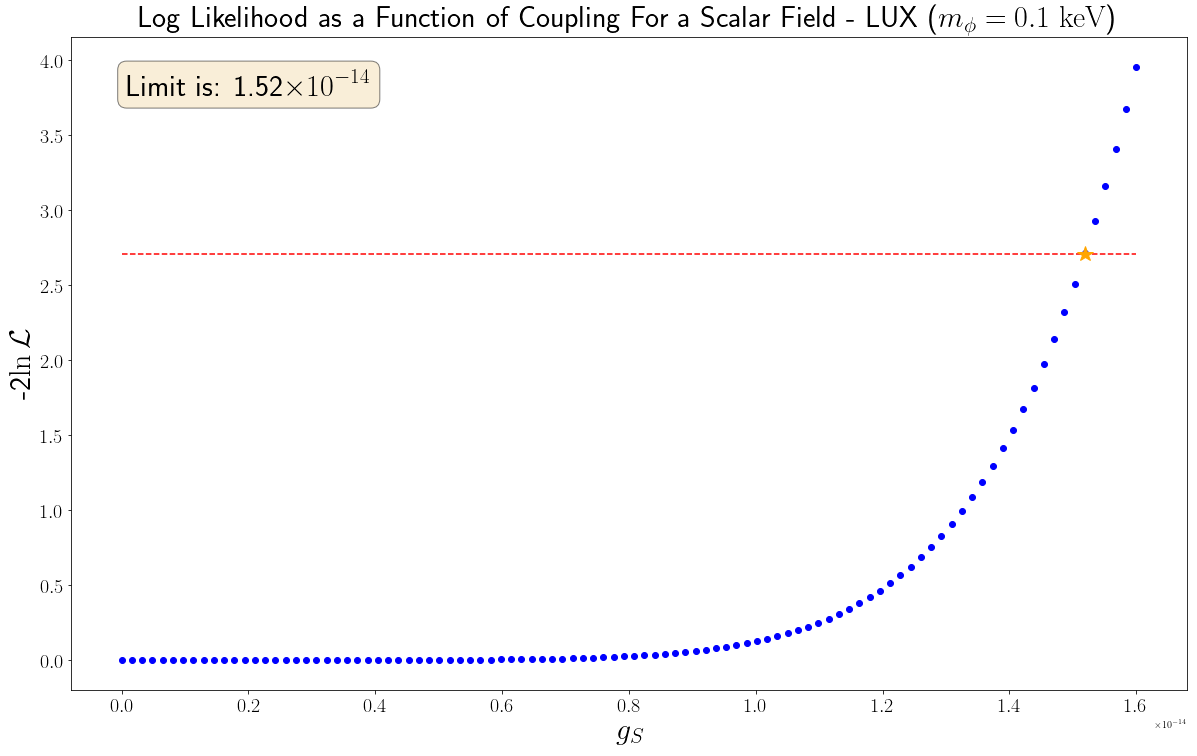

Limit is: 1.5189522322529006e-14
Number of signal events: 13.464274161849591
3.2412631511688232


In [29]:
start = tm.time()
scalarLimitLUX = GetScalarLimits(r"LUX", 1, np.array([m_keV]), scalePower = scalePower)
print(tm.time() - start)

# LUX S1-Only Results

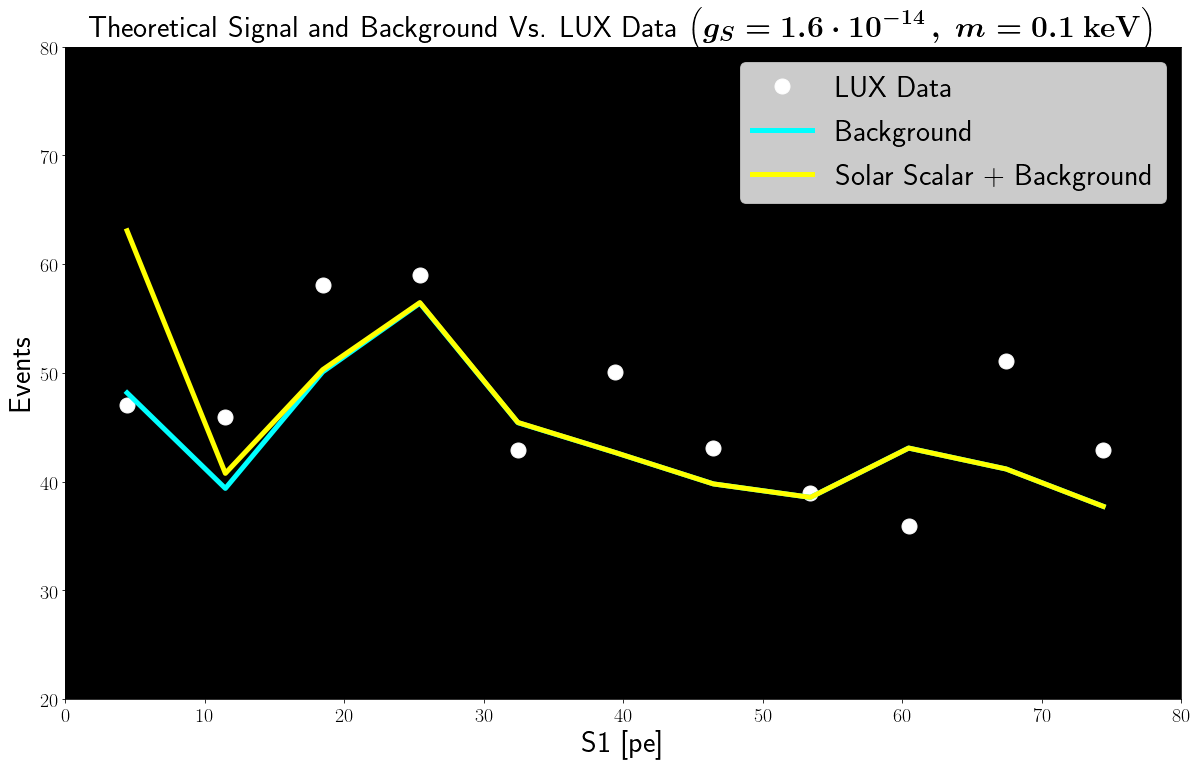

In [30]:
S                   = 1
couplingPower       = r"-14"
coefficient         = 1.6
gee                 = coefficient * BaseTenExponentiation(couplingPower)
m_keV               = 1e-1
SeventDensity_1_keV = LUXExposure_Mgy * SolarRate(S, gee, m_keV, r"Scalar")

sumedSignalScalar   = GetSignalInSBins(SeventDensity_1_keV, r"LUX", S)

_,ax = plt.subplots(figsize = [20, 12])
ax.plot(LUXDataBins, LUXData, r".", label = r"LUX Data", markersize = 30, color = r"white")
ax.plot(LUXDataBins, LUXBackground[:-1], linewidth = 5, label = r"Background", color = r"cyan")
ax.plot(LUXDataBins,
        LUXBackground[:-1] + sumedSignalScalar,
        linewidth = 5,
        label = r"Solar Scalar + Background",
        color = r"yellow")
plt.setp(ax.get_xticklabels(), fontsize = 20)
plt.setp(ax.get_yticklabels(), fontsize = 20)
ax.set_title(r"Theoretical Signal and Background Vs. LUX Data "
                                                 + CouplingPowerAndMassToLaTeX(couplingPower, m_keV, coefficient),
             fontweight = r"bold",
             size = 30)
ax.set_xlabel(r"S1 [pe]", fontsize = 30)
ax.set_ylabel(r"Events", fontsize = 30)
ax.set(xlim = [0, 80], ylim = [20, 80])
ax.legend(fontsize = 30)
ax.set_facecolor(r"xkcd:black")
plt.show()

## XENON1T

In [31]:
bosonType  = r"Scalar"
experiment = r"XENON1T"
S          = 1
scalePower = r"15" # Aesthetic reasons only. Note that the bound should be O(1) / 10^scalePower.
scale      = BaseTenExponentiation(scalePower)
m_keV      = 1e-1
#methods = [r"Nelder-Mead", r"Powell", r"CG", r"BFGS", r"TNC", r"COBYLA"]
#for method in methods:
#    minimum = minimize(ProfileLikelihood,
#                       0 / scale,
#                       (m_keV, bosonType, experiment, S,),
#                       tol = 1e-20,
#                       method = method)
#    print(method,
#          r"- fun:",
#          minimum.fun,
#          r", fun(" + format(minimum.x[0]) + r") =",
#          ProfileLikelihood(minimum.x[0], m_keV, bosonType, experiment, S))

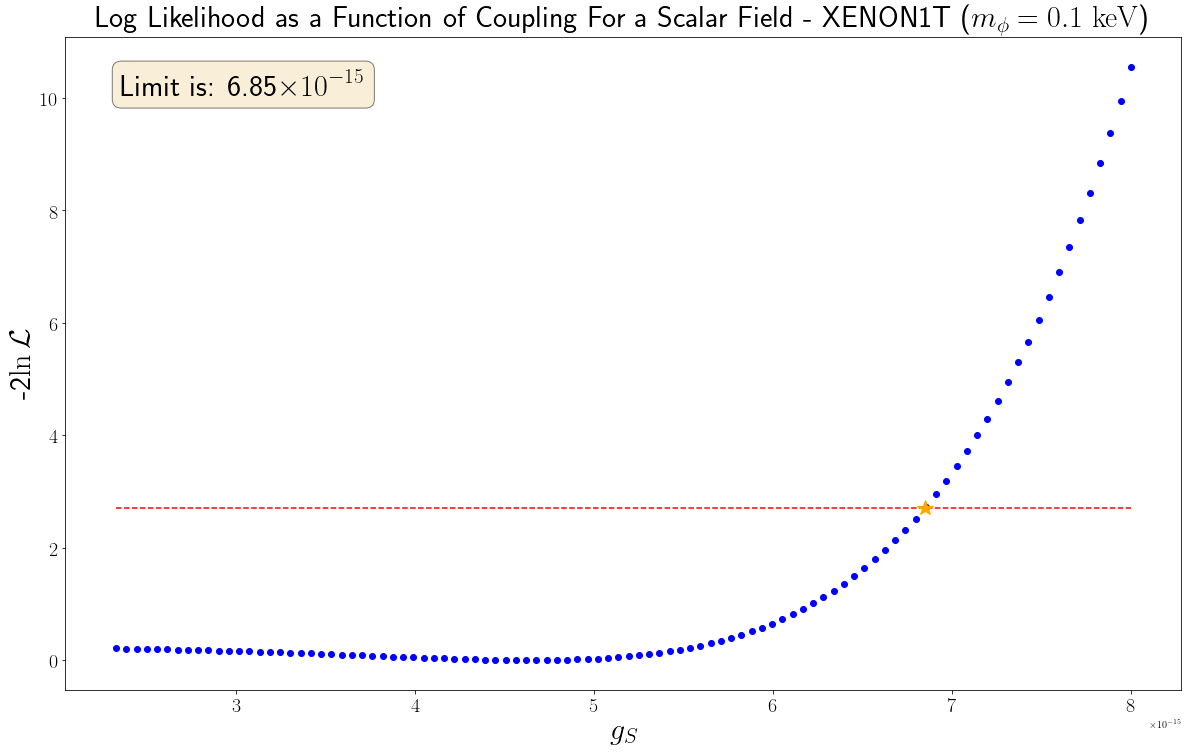

Limit is: 6.848626094435449e-15
Number of signal events: 18.689243709978797
2.646207094192505


In [32]:
start = tm.time()
scalarLimitXENON1T = GetScalarLimits(r"XENON1T", 1, np.array([m_keV]), scalePower = scalePower)
print(tm.time() - start)

In [33]:
print(r"Number of scalar signal events (LUX):", ProfileLikelihood(1e-14, m_keV, r"Scalar", r"LUX", 1, True)[1])
print(r"Number of scalar signal events (XENON1T):",
      ProfileLikelihood(1e-14, m_keV, r"Scalar", r"XENON1T", 1, True)[1])

Number of scalar signal events (LUX): 2.5293357380670023
Number of scalar signal events (XENON1T): 84.95284005713323


## XENONnT

In [34]:
bosonType  = r"Scalar"
experiment = r"XENONnT"
S          = 1
scalePower = r"15" # Aesthetic reasons only. Note that the bound should be O(1) / 10^scalePower.
scale      = BaseTenExponentiation(scalePower)
m_keV      = 1e-1
#methods = [r"Nelder-Mead", r"Powell", r"CG", r"BFGS", r"TNC", r"COBYLA"]
#for method in methods:
#    minimum = minimize(ProfileLikelihood,
#                       0 / scale,
#                       (m_keV, bosonType, experiment, S,),
#                       tol = 1e-20,
#                       method = method)
#    print(method,
#          r"- fun:",
#          minimum.fun,
#          r", fun(" + format(minimum.x[0]) + r") =",
#          ProfileLikelihood(minimum.x[0], m_keV, bosonType, experiment, S))

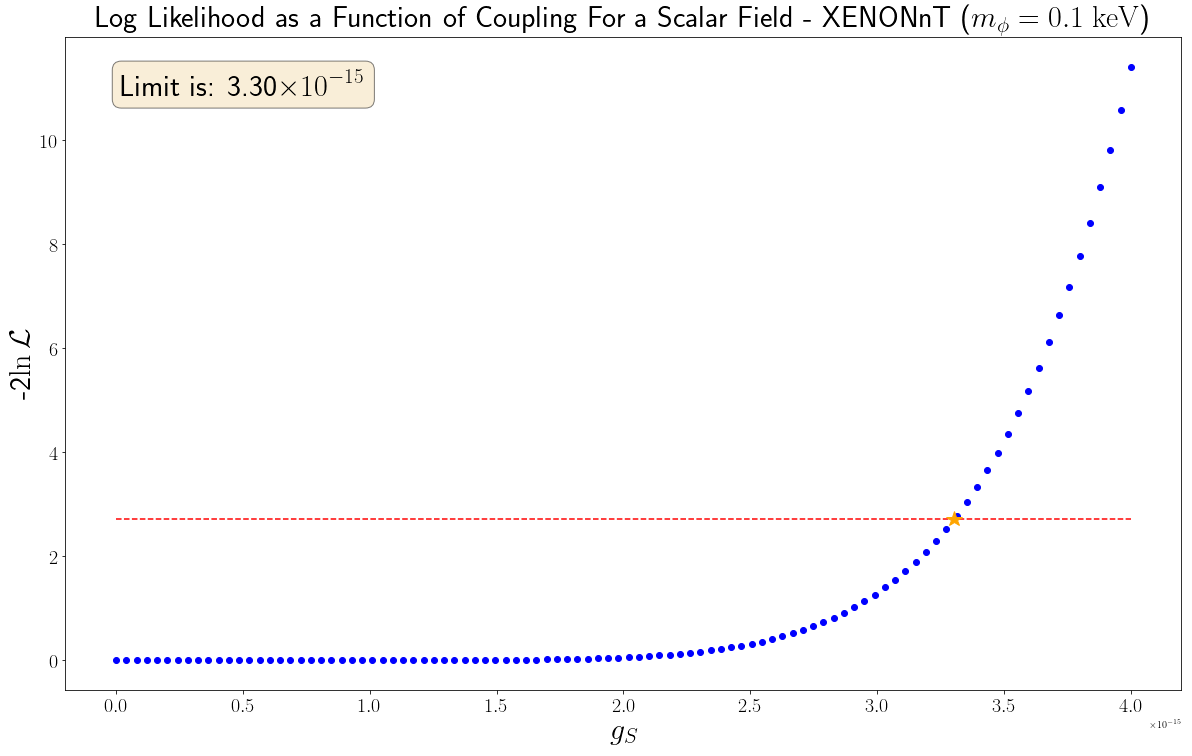

Limit is: 3.3025541068196505e-15
Number of signal events: 22.703833395061086
0.8293859958648682


In [35]:
start = tm.time()
scalarLimitXENONnT   = GetScalarLimits(r"XENONnT", 1, np.array([m_keV]), scalePower = scalePower)
print(tm.time() - start)

## XENON1T - S2

In [36]:
bosonType  = r"Scalar"
experiment = r"XENON1T"
S          = 2
m_keV      = 0

0.0040247440338134766
Overall signal events - Scalar: 4.925669164031473


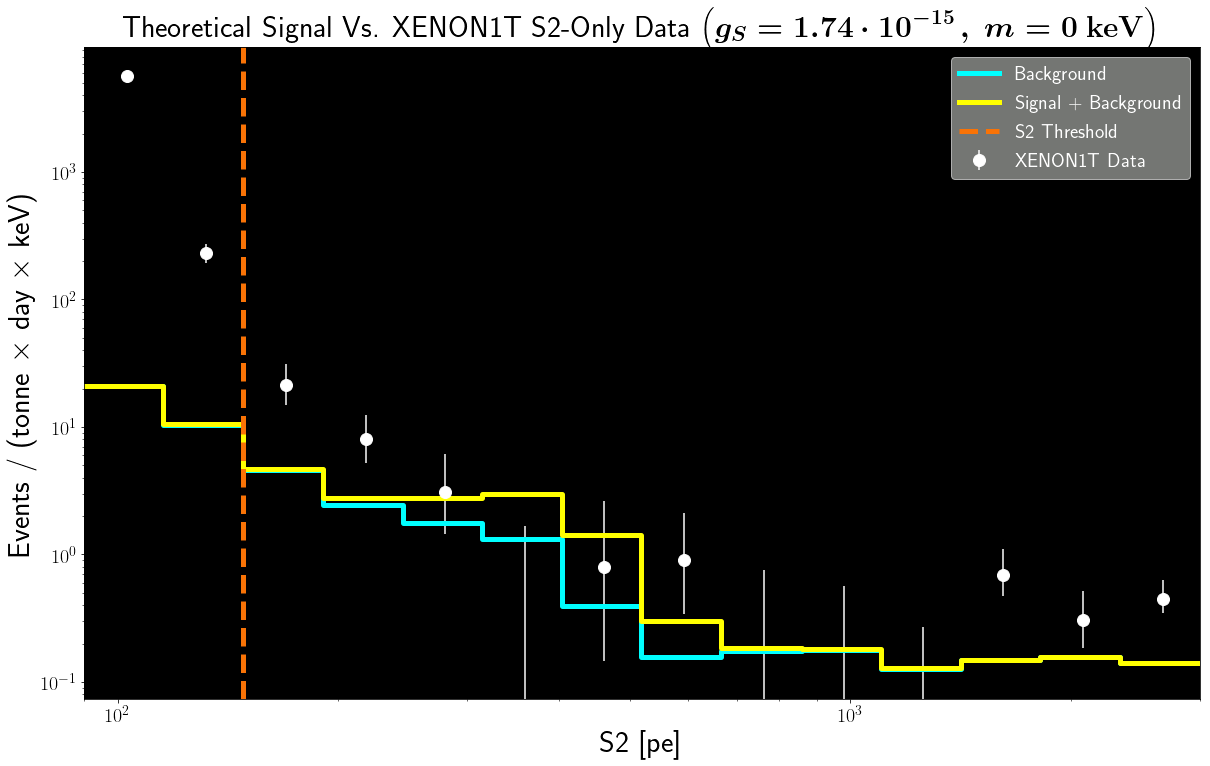

In [37]:
couplingPower         = r"-15"
coefficient           = 1.74
gee                   = coefficient * BaseTenExponentiation(couplingPower)

eventDensity_1_keV = XENON1TS2Exposure_Mgy * SolarRate(S, gee, m_keV, bosonType)
start = tm.time()
summedSignal_1_MgdkeV = GetSignalInSBins(eventDensity_1_keV, experiment, S, True)[1]
print(tm.time() - start)

print(r"Overall signal events - Scalar:", GetXENON1TS2SignalSum(summedSignal_1_MgdkeV[2:]))

_,ax = plt.subplots(figsize = [20, 12])
ax.set_xscale(r"log")
ax.set_yscale(r"log")
ax.errorbar(XENON1TS2Bins_pe,
            XENON1TS2Data_1_MgdkeV,
            yerr = [XENON1TS2LowerError_1_MgdkeV, XENON1TS2UpperError_1_MgdkeV],
            fmt = r"o",
            markersize = 12,
            label = r"XENON1T Data",
            color = r"white")
ax.step(XENON1TS2BinsBoundaries_pe,
        XENON1TS2Background_1_MgdkeV,
        linewidth = 5,
        where = r"post",
        label = r"Background",
        color = r"cyan")
#ax.loglog(XENON1TS2Bins_pe,
#          summedSignal_1_MgdkeV + XENON1TS2Background_1_MgdkeV,
#          r"*",
#          markersize = 16,
#          label = r"Signal + Background",
#          color = r"orange")
ax.step(XENON1TS2BinsBoundaries_pe,
        np.concatenate((summedSignal_1_MgdkeV[:], [summedSignal_1_MgdkeV[-1]])) + XENON1TS2Background_1_MgdkeV,
        linewidth = 5,
        where = r"post",
        label = r"Signal + Background",
        color = r"yellow")
ax.axvline(148.5, linewidth = 5, linestyle = r"dashed", label = r"S2 Threshold", color = r"xkcd:orange")
plt.setp(ax.get_xticklabels(), fontsize = 20)
plt.setp(ax.get_yticklabels(), fontsize = 20)
ax.set_title(r"Theoretical Signal Vs. XENON1T S2-Only Data "
                                                 + CouplingPowerAndMassToLaTeX(couplingPower, m_keV, coefficient),
             fontweight = r"bold",
             size = 30)
ax.set_xlabel(r"S2 [pe]", fontsize = 30)
ax.set_ylabel(r"Events / (tonne \(\times\) day \(\times\) keV)", fontsize = 30)
ax.set(xlim = [90, 3000]) # , ylim = [0, 100])
leg = ax.legend(fontsize = 20, facecolor = r"xkcd:gray")
for text in leg.get_texts():
    text.set_color(r"xkcd:white")
ax.set_facecolor(r"xkcd:black")
plt.show()

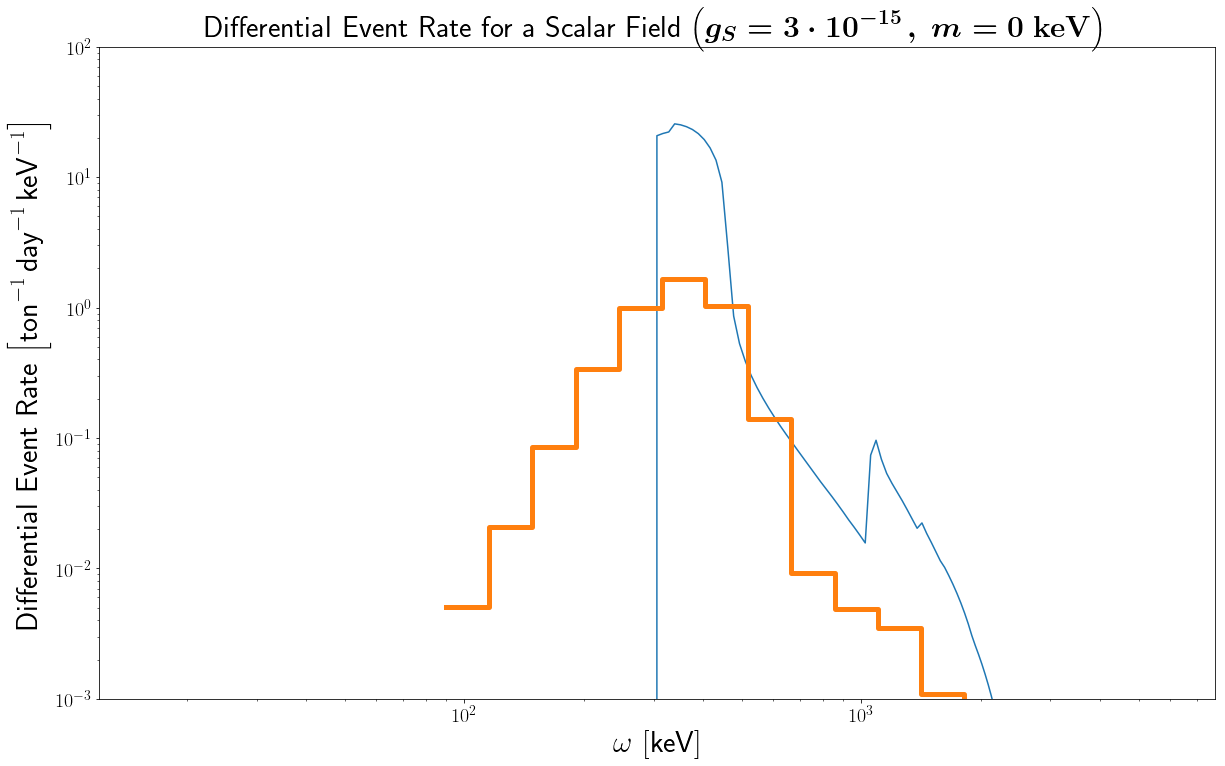

In [38]:
S              = 2
couplingPower  = r"-15"
coefficient    = 3
gee            = coefficient * BaseTenExponentiation(couplingPower)
m_keV          = 0
bosonType      = r"Scalar"
physicalObject = r"Differential Event Rate"
rate_1_MgdkeV  = SolarRate(S, gee, m_keV, bosonType) * day_s_d / year_s_y
title  = MakeTitle(physicalObject, bosonType, couplingPower, m_keV, coefficient)
xlabel = r"$\displaystyle{\omega\,\left[\text{keV}\right]}$"
ylabel = physicalObject + r" $\displaystyle{\left[\text{ton}^{-1}\,\text{day}^{-1}\,\text{keV}^{-1}\right]}$"
_,ax = plt.subplots(figsize = [20, 12])
ax.loglog(S2ExpectationValue_pe, rate_1_MgdkeV)
ax.step(XENON1TS2BinsBoundaries_pe,
        np.concatenate((summedSignal_1_MgdkeV[:], [summedSignal_1_MgdkeV[-1]])),
        linewidth = 5,
        where = r"post")
plt.setp(ax.get_xticklabels(), fontsize = 20)
plt.setp(ax.get_yticklabels(), fontsize = 20)
ax.set_title(title, fontweight = r"bold", size = 30)
ax.set_xlabel(xlabel, fontsize = 30)
ax.set_ylabel(ylabel, fontsize = 30)
ax.set(ylim = [1e-3, 1e2])
plt.show()

In [39]:
bosonType     = r"Scalar"
experiment    = r"XENON1T"
S             = 2
scalePower    = r"15" # Aesthetic reasons only. Note that the bound should be O(1) / 10^scalePower.
scale         = BaseTenExponentiation(scalePower)
m_keV         = 0
initialgPLMin = 0
#methods = [r"Nelder-Mead", r"Powell", r"CG", r"BFGS", r"TNC", r"COBYLA"]
#for method in methods:
#    minimum = minimize(ProfileLikelihood,
#                       initialgPLMin,
#                       (m_keV, bosonType, experiment, S,),
#                       tol = 1e-20,
#                       method = method)
#    print(method,
#          r"- fun:",
#          minimum.fun,
#          r", fun(" + format(minimum.x) + r") =",
#          ProfileLikelihood(minimum.x, m_keV, bosonType, experiment, S))

minLikelihood =  -48.91321623729124
gPLMin =  1.3995600468483254e-15


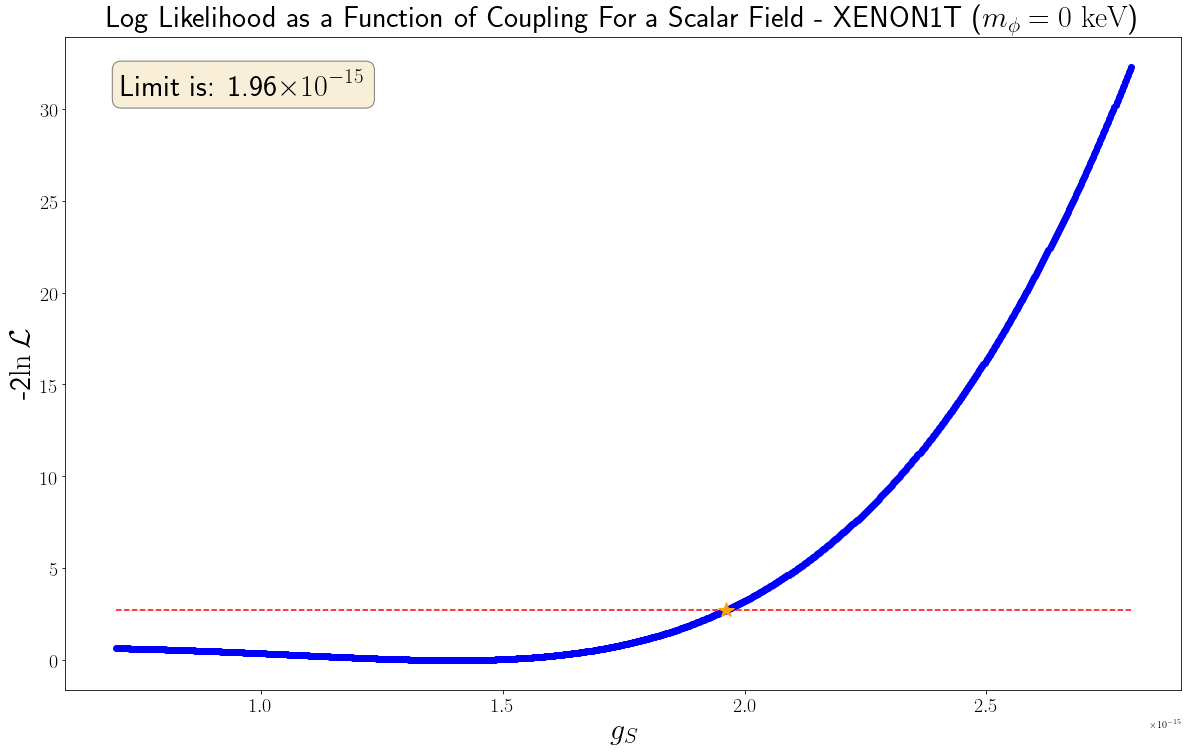

Limit is: 1.960657190917305e-15
0.003117799758911133
Number of signal events: 7.940994803128702


In [40]:
minLikelihoodObject = minimize(ProfileLikelihood,
                               initialgPLMin,
                               (m_keV, bosonType, experiment, S,),
                               tol = 1e-20,
                               method = r"Nelder-Mead")
minLikelihood       = minLikelihoodObject.fun
print(r"minLikelihood = ", minLikelihood)
gPLMin              = minLikelihoodObject.x[0]
print(r"gPLMin = ", gPLMin)
g                   = np.linspace(gPLMin / 2, gPLMin * 2, int(1e3))
PL                  = np.array([ProfileLikelihood(gg,
                                                  m_keV,
                                                  bosonType,
                                                  experiment,
                                                  S) for gg in g]) - minLikelihood
scalarLimitXENON1TS2OLD = PrintLimitOLD(g, m_keV, PL, gPLMin, scalePower, bosonType, experiment, S, True)

minLikelihood =  -48.91321623729124
gPLMin        =  1.3995600468483254e-15
limit   = 1.7121228613744396e-15
limit0  = 1.8140461803359225e-15
limitJ  = 1.9516007812206935e-15
limit0J = 1.897432490410979e-15


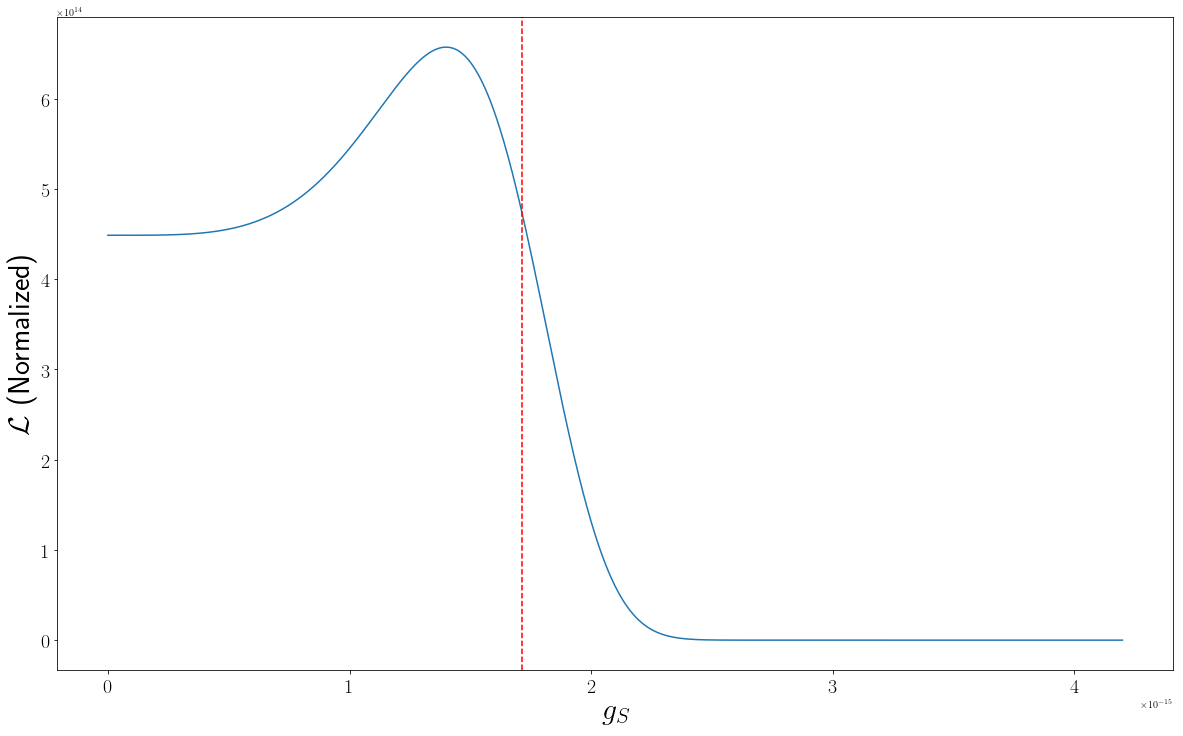

In [41]:
minLikelihoodObject    = minimize(ProfileLikelihood,
                                  initialgPLMin,
                                  (m_keV, bosonType, experiment, S,),
                                  tol = 1e-20,
                                  method = r"Nelder-Mead")
minLikelihood          = minLikelihoodObject.fun
print(r"minLikelihood = ", minLikelihood)
gPLMin                 = minLikelihoodObject.x[0]
print(r"gPLMin        = ", gPLMin)

g                      = np.linspace(0, gPLMin * S2MaxFactor, int(1e3))
PL                     = np.array([ProfileLikelihood(gg,
                                                     m_keV,
                                                     bosonType,
                                                     experiment,
                                                     S) for gg in g]) - minLikelihood

L                  = np.exp(- PL / 2)
L0                 = L.copy()
L0[g < gPLMin]     = 0
normalizedL        = L / simps(L, g)
normalizedL0       = L0 / simps(L0, g)
normalizedLJ       = L / simps(4 * g**3 * L, g)
normalizedL0J      = L0 / simps(4 * g**3 * L0, g)
partialIntegrals   = np.zeros(normalizedL.size)
partialIntegrals0  = np.zeros(normalizedL0.size)
partialIntegralsJ  = np.zeros(normalizedL.size)
partialIntegrals0J = np.zeros(normalizedL0.size)
for i in range(normalizedL.size):
    partialIntegrals[i]   = simps(normalizedL[:i + 1], g[:i + 1])
    partialIntegrals0[i]  = simps(normalizedL0[:i + 1], g[:i + 1])
    partialIntegralsJ[i]  = simps(4 * g[:i + 1]**3 * normalizedLJ[:i + 1], g[:i + 1])
    partialIntegrals0J[i] = simps(4 * g[:i + 1]**3 * normalizedL0J[:i + 1], g[:i + 1])
#print(r"partialIntegrals       = ", partialIntegrals)
#print(r"partialIntegrals0      = ", partialIntegrals0)

limit   = np.interp(0.9, partialIntegrals, g)
limit0  = np.interp(0.8, partialIntegrals0, g)
limitJ  = np.interp(0.9, partialIntegralsJ, g)
limit0J = np.interp(0.8, partialIntegrals0J, g)
print(r"limit   =", limit)
print(r"limit0  =", limit0)
print(r"limitJ  =", limitJ)
print(r"limit0J =", limit0J)

_,ax = plt.subplots(figsize = [20, 12])
ax.plot(g, normalizedL)
ax.axvline(limit, linestyle = r"dashed", color = r"red")
plt.setp(ax.get_xticklabels(), fontsize = 20)
plt.setp(ax.get_yticklabels(), fontsize = 20)
ax.set_xlabel(r"\(g_{S}\)", fontsize = 30)
ax.set_ylabel(r"\(\mathcal{L}\) (Normalized)", fontsize = 30)
plt.show()

1.7121228597823373e-15
1.8172842495013514e-15


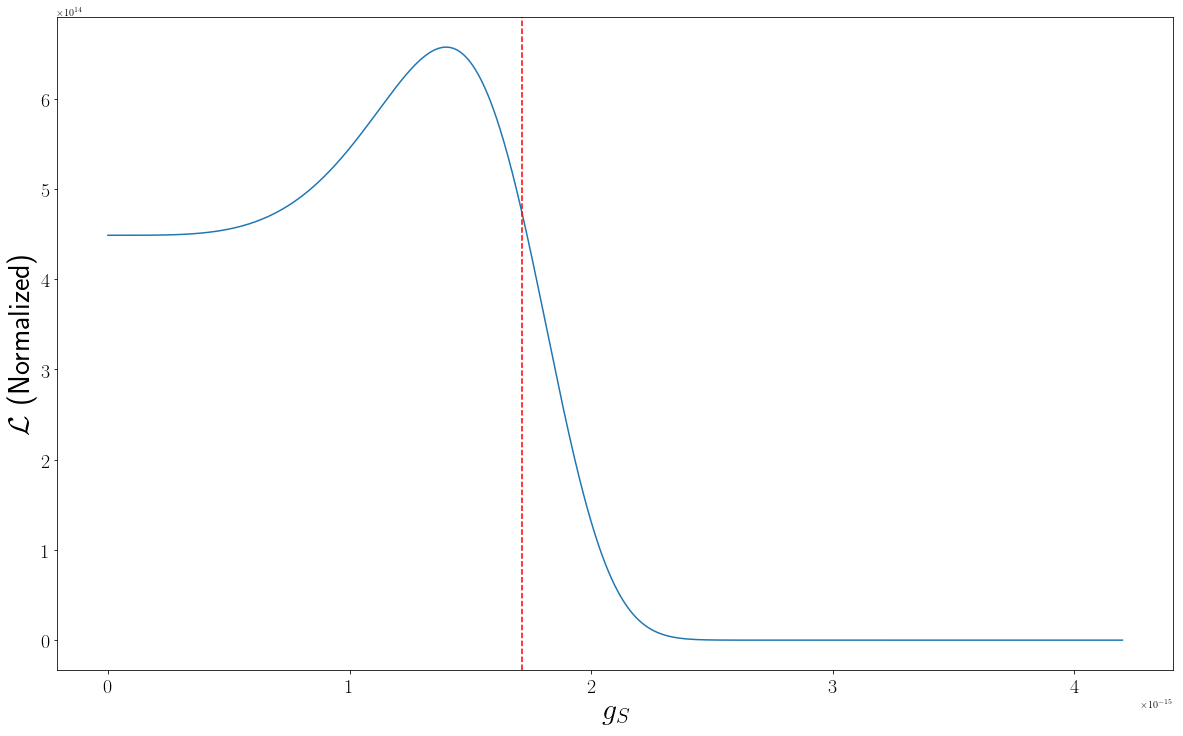

In [42]:
maxLikelihoodObject = minimize(MinusLikelihood,
                               initialgPLMin,
                               (m_keV, bosonType, experiment, S,),
                               tol = 1e-20,
                               method = r"Nelder-Mead")
gPLMax              = maxLikelihoodObject.x[0]
g                   = np.linspace(0, gPLMax * S2MaxFactor, int(1e3))
L                   = np.array([Likelihood(gg, m_keV, bosonType, experiment, S) for gg in g])
L0                  = L.copy()
L0[g < gPLMax]      = 0
normalizedL         = L / simps(L, g)
normalizedL0        = L0 / simps(L0, g)
partialIntegrals    = np.zeros(normalizedL.size)
partialIntegrals0   = np.zeros(normalizedL0.size)
for i in range(normalizedL.size):
    partialIntegrals[i]  = simps(normalizedL[:i + 1], g[:i + 1])
    partialIntegrals0[i] = simps(normalizedL0[:i + 1], g[:i + 1])

limit    = np.interp(0.9, partialIntegrals, g)
limit0   = np.interp(0.8, partialIntegrals0, g)
print(limit)
print(limit0)

_,ax = plt.subplots(figsize = [20, 12])
ax.plot(g, normalizedL)
ax.axvline(limit, linestyle = r"dashed", color = r"red")
plt.setp(ax.get_xticklabels(), fontsize = 20)
plt.setp(ax.get_yticklabels(), fontsize = 20)
ax.set_xlabel(r"\(g_{S}\)", fontsize = 30)
ax.set_ylabel(r"\(\mathcal{L}\) (Normalized)", fontsize = 30)
plt.show()

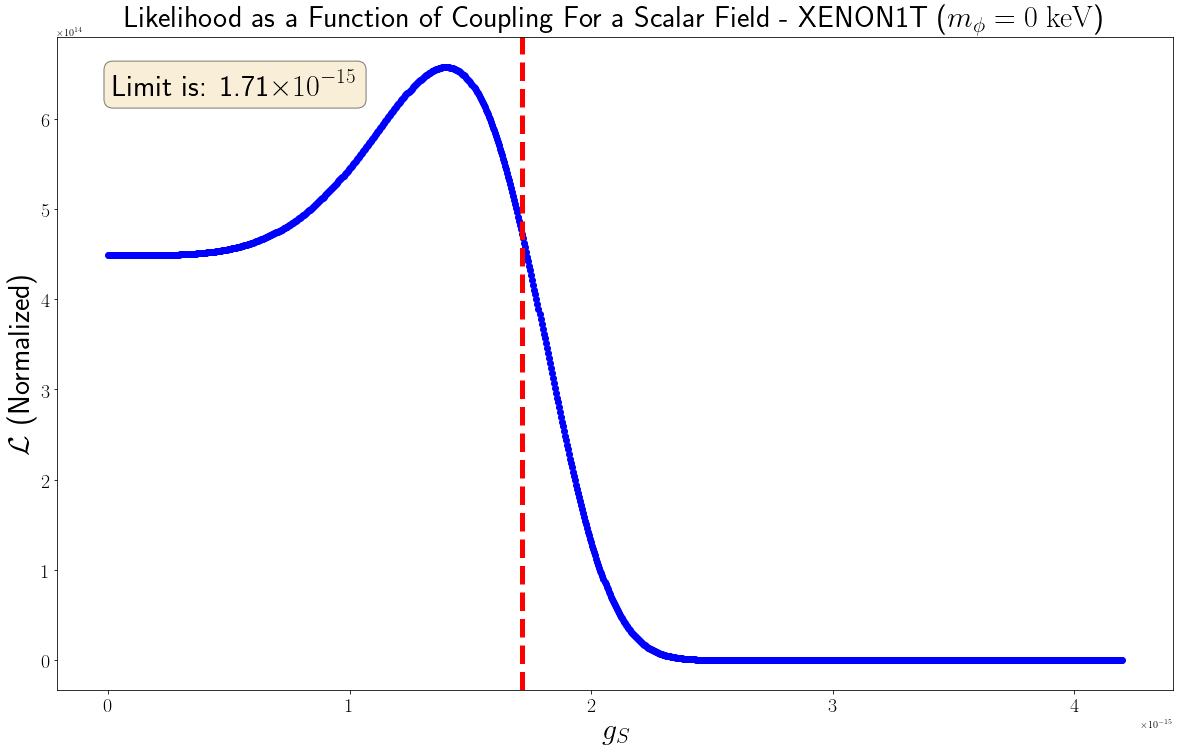

Limit is: 1.7121228613744396e-15
Number of signal events: 4.617511128794025
2.469165086746216


In [43]:
start = tm.time()
scalarLimitXENON1TS2 = GetScalarLimits(r"XENON1T", 2, np.array([m_keV]), int(1e3), scalePower)
print(tm.time() - start)

## Bound Vs. Mass

In [44]:
mMin_keV        = 1e-1
mMax_keV        = 2e0
mMinPower       = -2
mMaxPower       = 1
massPoints      = 306
#m_keV           = np.linspace(mMin_keV, mMax_keV, massPoints)
m_keV           = np.logspace(mMinPower, mMaxPower, massPoints)
m_keV           = m_keV[:m_keV.size - sum(m_keV > 2.03)]
print(m_keV.size)

235


In [45]:
scalePower      = r"14" # Aesthetic reasons only. Note that the bound should be O(1) / 10^scalePower.
scale           = BaseTenExponentiation(scalePower)
start = tm.time()
limitsLUX       = GetScalarLimits(r"LUX", 1, m_keV)
print(tm.time() - start)
#start = tm.time()
#limitsLUX       = GetScalarLimits(r"LUX",     1, 0 * 0.6 / scale, 2.6 / scale, m_keV, scalePower = scalePower)
#print(tm.time() - start)

34.37785601615906


In [46]:
scalePower    = r"15" # Aesthetic reasons only. Note that the bound should be O(1) / 10^scalePower.
scale         = BaseTenExponentiation(scalePower)
start = tm.time()
limitsXENON1T = GetScalarLimits(r"XENON1T", 1, m_keV)
print(tm.time() - start)
#start = tm.time()
#limitsXENON1T = GetScalarLimits(r"XENON1T", 1, 7 / scale, 100 / scale, np.array([1e-1]), scalePower = scalePower)
#print(tm.time() - start)

20.80954599380493


In [47]:
scalePower      = r"15" # Aesthetic reasons only. Note that the bound should be O(1) / 10^scalePower.
scale           = BaseTenExponentiation(scalePower)
start = tm.time()
limitsXENONnT   = GetScalarLimits(r"XENONnT", 1, m_keV)
print(tm.time() - start)
#start = tm.time()
#limitsXENONnT   = GetScalarLimits(r"XENONnT", 1, 3 / scale, 100 / scale, np.array([m_keV[0]]), int(1e3))
#print(tm.time() - start)

30.48734426498413


In [48]:
scalePower      = r"15" # Aesthetic reasons only. Note that the bound should be O(1) / 10^scalePower.
scale           = BaseTenExponentiation(scalePower)
start = tm.time()
limitsXENON1TS2 = GetScalarLimits(r"XENON1T", 2, m_keV, int(1e3))
print(tm.time() - start)
#start = tm.time()
#GetScalarLimits(r"XENON1T", 2, np.array([1e-1]), int(1e3), scalePower)
#print(tm.time() - start)
#start = tm.time()
#limitsXENON1TS2 = GetScalarLimits(r"XENON1T", 2, np.array([3.5e-1]), int(1e3), scalePower)
#print(tm.time() - start)

486.0913097858429


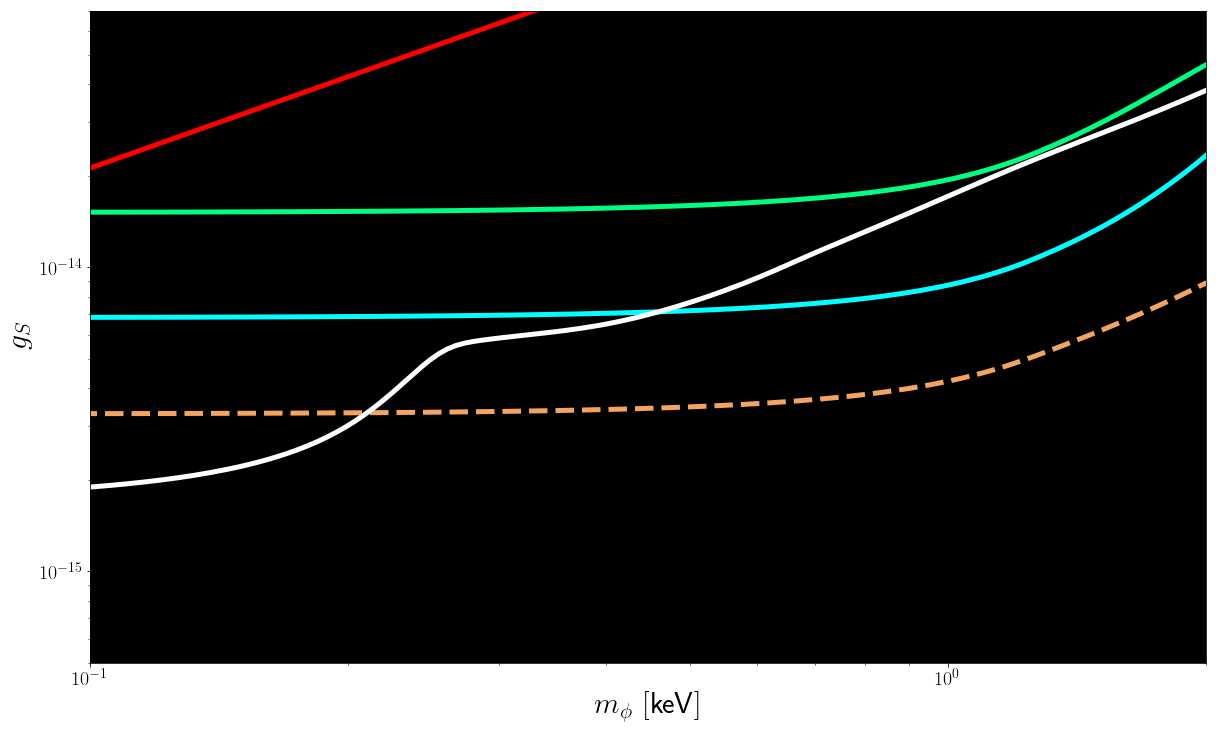

In [50]:
xlabel = r"$\displaystyle{m_{\phi}\,\left[\text{keV}\right]}$"
ylabel = r"$\displaystyle{g_{S}}$"

ylimMax = 7e-14
ylimMin = 5e-16

colorLUX         = r"SpringGreen"
colorXENON1T     = r"cyan"
colorXENONnT     = r"SandyBrown"
colorXENON1TS2   = r"white"
colorNaturalness = r"red"

_,ax = plt.subplots(figsize = [20, 12])
LUXPlot         = ax.loglog(m_keV, limitsLUX, color = colorLUX, linewidth = 5, label = r"LUX")
XENON1TPlot     = ax.loglog(m_keV, limitsXENON1T, color = colorXENON1T, linewidth = 5, label = r"XENON1T")
XENONnTPlot     = ax.loglog(m_keV,
                            limitsXENONnT,
                            color = colorXENONnT,
                            linestyle = r"dashed",
                            linewidth = 5,
                            label = r"XENONnT (Projected)")
XENON1TS2Plot   = ax.loglog(m_keV,
                            limitsXENON1TS2,
                            color = colorXENON1TS2,
                            linewidth = 5,
                            label = r"XENON1T (Resonant)")
naturalnessPlot = ax.loglog(m_keV,
                            2 * tau * Me_keV * m_keV / (174 * const.giga / const.kilo)**2,
                            color = colorNaturalness,
                            linewidth = 5,
                            label = r"Naturalness")
plt.setp(ax.get_xticklabels(), fontsize = 20)
plt.setp(ax.get_yticklabels(), fontsize = 20)
ax.set_xlabel(xlabel, fontsize = 30)
ax.set_ylabel(ylabel, fontsize = 30)
ax.set(xlim = [mMin_keV, mMax_keV], ylim = [ylimMin, ylimMax])
#ax.legend(fontsize = 30, loc = 1)
ax.set_facecolor(r"xkcd:black")
plt.show()

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  # This is added back by InteractiveShellApp.init_path()
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.


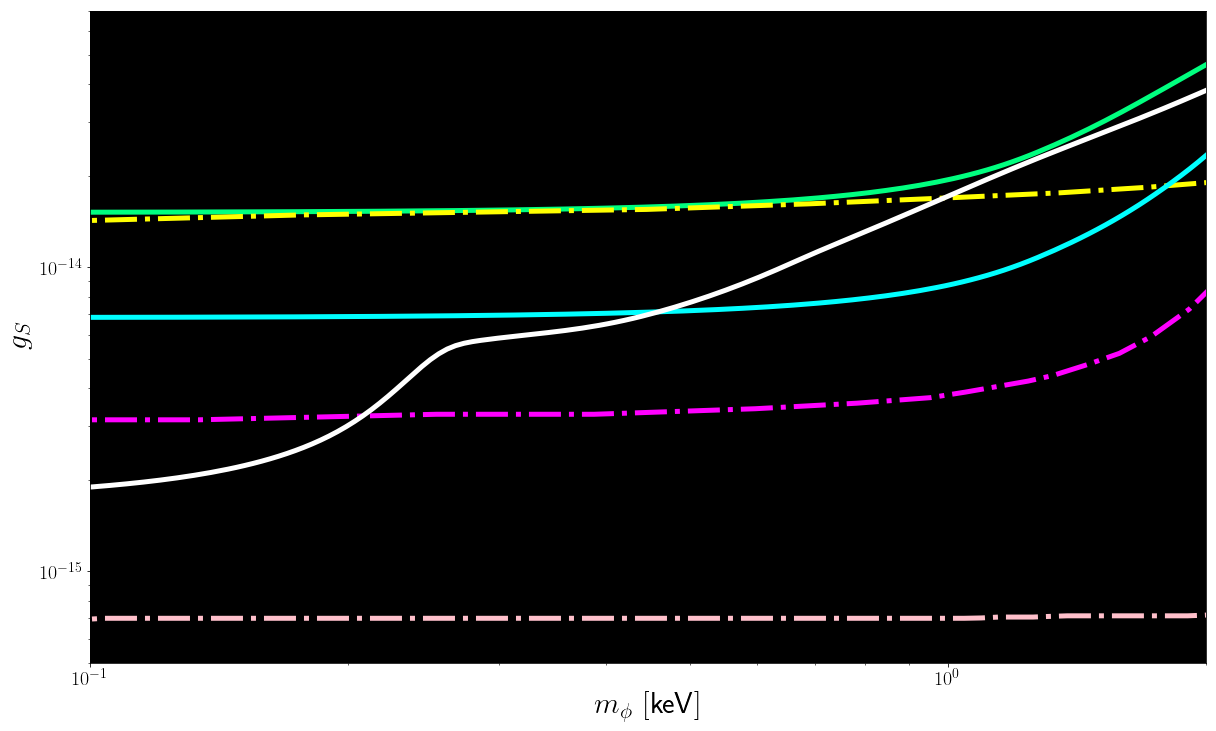

In [51]:
xlabel = r"$\displaystyle{m_{\phi}\,\left[\text{keV}\right]}$"
ylabel = r"$\displaystyle{g_{S}}$"

ylimMax = 7e-14
ylimMin = 5e-16

colorHBContinuum = r"yellow"
colorHBResonance = r"fuchsia"
colorRGResonance = r"pink"

HBContinuumLimit      = pd.read_csv(r"Horizontal Branch.txt", sep = r"\t", header = None).get_values()
mHBContinuumLimit_keV = HBContinuumLimit[:,0]
gHBContinuumLimit     = np.sqrt(2 * tau * HBContinuumLimit[:,1])
HBResonanceLimit      = pd.read_csv(r"Horizontal Branch (Resonant).txt", sep = r"\t", header = None).get_values()
mHBResonanceLimit_keV = HBResonanceLimit[:,0]
gHBResonanceLimit     = np.sqrt(2 * tau * HBResonanceLimit[:,1])
RGResonanceLimit      = pd.read_csv(r"Red Giants (Resonant).txt", sep = r"\t", header = None).get_values()
mRGResonanceLimit_keV = RGResonanceLimit[:,0]
gRGResonanceLimit     = np.sqrt(2 * tau * RGResonanceLimit[:,1])

_,ax = plt.subplots(figsize = [20, 12])
LUXPlot         = ax.loglog(m_keV, limitsLUX, color = colorLUX, linewidth = 5, label = r"LUX")
HBContinuumPlot = ax.loglog(mHBContinuumLimit_keV,
                            gHBContinuumLimit,
                            color = colorHBContinuum,
                            linestyle = r"-.",
                            linewidth = 5,
                            label = r"HB Continuum")
XENON1TPlot     = ax.loglog(m_keV, limitsXENON1T, color = colorXENON1T, linewidth = 5, label = r"XENON1T")
HBResonancePlot = ax.loglog(mHBResonanceLimit_keV,
                            gHBResonanceLimit,
                            color = colorHBResonance,
                            linestyle = r"-.",
                            linewidth = 5,
                            label = r"HB Resonant Production")
XENON1TS2Plot   = ax.loglog(m_keV,
                            limitsXENON1TS2,
                            color = colorXENON1TS2,
                            linewidth = 5,
                            label = r"XENON1T (Resonant)")
RGResonancePlot = ax.loglog(mRGResonanceLimit_keV,
                            gRGResonanceLimit,
                            color = colorRGResonance,
                            linestyle = r"-.",
                            linewidth = 5,
                            label = r"Red Giants Resonant Production")
plt.setp(ax.get_xticklabels(), fontsize = 20)
plt.setp(ax.get_yticklabels(), fontsize = 20)
ax.set_xlabel(xlabel, fontsize = 30)
ax.set_ylabel(ylabel, fontsize = 30)
ax.set(xlim = [mMin_keV, mMax_keV], ylim = [ylimMin, ylimMax])
#ax.legend(fontsize = 30, loc = 1)
ax.set_facecolor(r"xkcd:black")
plt.show()